# 1. Introduction


In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as pyplt
%matplotlib inline
import keras as ks
import sklearn.preprocessing as pre
import sklearn.model_selection as mod
import sklearn.decomposition as dec
from sklearn.utils import shuffle
from sklearn.datasets import load_boston
boston = load_boston()

Using TensorFlow backend.
c:\users\conor\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\conor\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\conor\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\conor\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
#df = pd.DataFrame(boston.data, columns=boston.feature_names)
#df['target'] = boston.target

In [3]:
df = pd.DataFrame(boston.data)
df['Median_Value'] = boston.target

In [4]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,Median_Value
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


### About the Dataset

This dataset was created from data taken from the 1970 United States census and other sources and used in a paper investigating the willingness of people to pay more for clean air in the Boston housing market. 

Harrison, D. and Rubinfeld, D. (1978). Hedonic housing prices and the demand for clean air. Journal of Environmental Economics and Management, 5(1), pp.81-102.

The scikit learn source includes a description file that can be printed to learn more about the dataset and it's features:

In [5]:
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

However, I found the above descriptions the datasets attributes to be unclear so I read the original source paper to get more detail. My updated decscriptions are included below are based on Table IV in the source paper.

|Orginal Attribute Name|New Name|Description|Assumed Relationship to Housing Values|
|:------------------------|:---------|:-----------|:------------------------------|
|CRIM|Crime_Rate|Crime rate by town|Negative|
|ZN|%_Large_Plots|Proportion of residential land zoned for large plots|Postive|
|INDUS|%_Indus|Proportion of land zoned for industrial use|Negative|
|CHAS|By_River|Boolean value for whether the land borders the Charles River|Positive|
|NOX|NOX|Nitrogen oxide concentrations in the air|Negative|
|RM|Rooms|Average number of rooms in houses|Positive|
|AGE|%_Pre_1940|Proporation of houses constructed before 1940. Older housing is of good quality in Boston|Positive|
|DIS|Dist_to_Jobs|Weighted distance to places of employment|Positive|
|RAD|Highway_Access|Index of accessabilty to highways|Positive|
|TAX|Tax|Property Tax rate in the area|Negative|
|PTRATIO|PTRatio|Pupil-Teacher ration in the area. Higher values mean more students per teacher|Negative|
|B|Blks_per_1000|Proportion of the population that are black. Regarded as undisirable by Whites|Negative|
|LSTAT|%_Lower_Status|Proportion of adults without a high school education or male laborers|Negative|

### Adding more readable column names

In [6]:
#setting columns names
df.columns = ["Crime_Rate", "%_Large_Plots", "%_Indus", "By_River", "NOX", "Rooms", "%_Pre_1940", "Dist_to_Jobs", "Highway_Access", "Tax", "PTRatio", "Blks_per_1000", "%_Lower_Status", "Median_Val"]

In [7]:
#checking the new column names line up 
df.head()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [8]:
df.tail()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0
505,0.04741,0.0,11.93,0.0,0.573,6.030,80.8,2.5050,1.0,273.0,21.0,396.90,7.88,11.9


In [9]:
df.columns

Index(['Crime_Rate', '%_Large_Plots', '%_Indus', 'By_River', 'NOX', 'Rooms',
       '%_Pre_1940', 'Dist_to_Jobs', 'Highway_Access', 'Tax', 'PTRatio',
       'Blks_per_1000', '%_Lower_Status', 'Median_Val'],
      dtype='object')

# 2. Descriptive Analysis

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
Crime_Rate        506 non-null float64
%_Large_Plots     506 non-null float64
%_Indus           506 non-null float64
By_River          506 non-null float64
NOX               506 non-null float64
Rooms             506 non-null float64
%_Pre_1940        506 non-null float64
Dist_to_Jobs      506 non-null float64
Highway_Access    506 non-null float64
Tax               506 non-null float64
PTRatio           506 non-null float64
Blks_per_1000     506 non-null float64
%_Lower_Status    506 non-null float64
Median_Val        506 non-null float64
dtypes: float64(14)
memory usage: 55.5 KB


#### Distribution of values

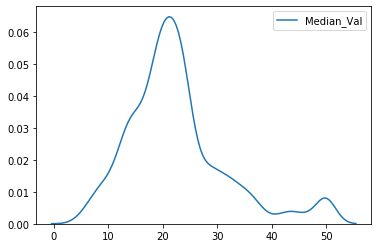

In [11]:
sns.kdeplot(df['Median_Val'])

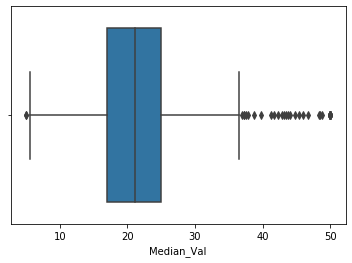

In [12]:
sns.boxplot(df['Median_Val'])

In [13]:
df.describe()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


There are lots of outliers in the upper range of values

### Note look at this article 
https://www.ritchieng.com/machine-learning-project-boston-home-prices/

Good examples of data exoplorations and statistics on pricing 
And linear regression later on.

Creating a corrolation matrix to see if there is any relationship betweek the variables.

In [14]:
corr_matrix = df.corr().round(2)
corr_matrix.style.background_gradient(cmap='coolwarm')

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
Crime_Rate,1,-0.2,0.41,-0.06,0.42,-0.22,0.35,-0.38,0.63,0.58,0.29,-0.39,0.46,-0.39
%_Large_Plots,-0.2,1,-0.53,-0.04,-0.52,0.31,-0.57,0.66,-0.31,-0.31,-0.39,0.18,-0.41,0.36
%_Indus,0.41,-0.53,1,0.06,0.76,-0.39,0.64,-0.71,0.6,0.72,0.38,-0.36,0.6,-0.48
By_River,-0.06,-0.04,0.06,1,0.09,0.09,0.09,-0.1,-0.01,-0.04,-0.12,0.05,-0.05,0.18
NOX,0.42,-0.52,0.76,0.09,1,-0.3,0.73,-0.77,0.61,0.67,0.19,-0.38,0.59,-0.43
Rooms,-0.22,0.31,-0.39,0.09,-0.3,1,-0.24,0.21,-0.21,-0.29,-0.36,0.13,-0.61,0.7
%_Pre_1940,0.35,-0.57,0.64,0.09,0.73,-0.24,1,-0.75,0.46,0.51,0.26,-0.27,0.6,-0.38
Dist_to_Jobs,-0.38,0.66,-0.71,-0.1,-0.77,0.21,-0.75,1,-0.49,-0.53,-0.23,0.29,-0.5,0.25
Highway_Access,0.63,-0.31,0.6,-0.01,0.61,-0.21,0.46,-0.49,1,0.91,0.46,-0.44,0.49,-0.38
Tax,0.58,-0.31,0.72,-0.04,0.67,-0.29,0.51,-0.53,0.91,1,0.46,-0.44,0.54,-0.47


In [15]:
median_val_corr = corr_matrix.iloc[-1]
median_val_corr.sort_values(ascending=True)

%_Lower_Status   -0.74
PTRatio          -0.51
%_Indus          -0.48
Tax              -0.47
NOX              -0.43
Crime_Rate       -0.39
%_Pre_1940       -0.38
Highway_Access   -0.38
By_River          0.18
Dist_to_Jobs      0.25
Blks_per_1000     0.33
%_Large_Plots     0.36
Rooms             0.70
Median_Val        1.00
Name: Median_Val, dtype: float64

The average number of Rooms per House (0.7) and the % of People of Lower Status (-0.74) are the mostly strongly corrolated with the Median Value of houses

Also, worth noting the high corrolation between NOX and industrialisation (0.76) , Tax and Access to Highways (0.91)

### Corrolation and Sensitivity to different variables

1. Benefit of less NOX drops when DIS and RAD are removed. This is because the advantages of greater accessability cancel out the disadvantages of less clean air. 
2. The affect of higher NOX levels can easily be attributed to a higher proportion of lower status households. 
3. In general there is a high degree of heteroscedasticity. As X increases there is a larger variance in Y. 

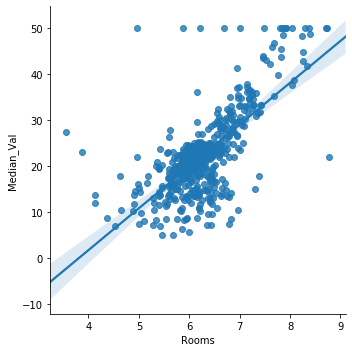

In [16]:
sns.lmplot(x="Rooms", y="Median_Val", data=df)

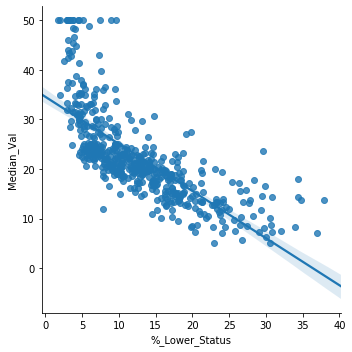

In [17]:
sns.lmplot(x="%_Lower_Status", y="Median_Val", data=df)

Looking at 2 next most closely corrolated attributes: Crime rate and Pupil teacher ratio shows there is a far less obvious relationship.

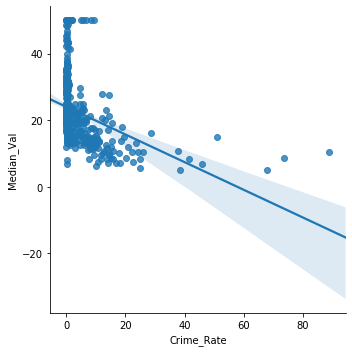

In [18]:
# lmplot of a weakly corrolated value "Distance to areas of employement (Dist_to_Jobs)"
sns.lmplot(x="Crime_Rate", y="Median_Val", data=df)

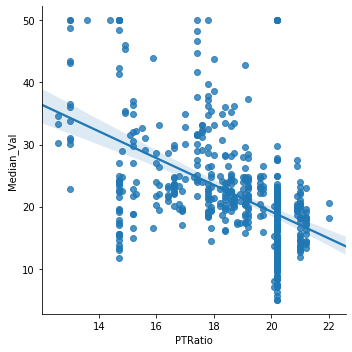

In [19]:
# lmplot of a weakly corrolated value "Distance to areas of employement (Dist_to_Jobs)"
sns.lmplot(x="PTRatio", y="Median_Val", data=df)

# 3. Inferential Statistics

#### Objective 2: Analyse whether there is a significant difference between median house prices between houses that are along the Charles river and those that aren't.

The first attribute who's effect on housing prices that I was asked to investigate is whether the house is by the Charles River or not ("CHAS" or "By_River").

In the original paper this dataset was derived from, the authors assumed there would be a positive relationship between being next to the river and housing prices.

As I have shown above, there only seems to be a very week positive corrolation (0.18).

In order to investigate further I have performed a T-Test below..

In [20]:
# getting the count of areas next to the Charles river
count_by_river = len(df[df['By_River'] == 1.0])
count_by_river

35

In [21]:
# getting the count of areas away from the Charles River
count_away_from_river = len(df[df['By_River'] == 0.0])
count_away_from_river

471

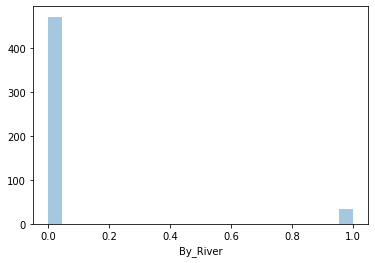

In [22]:
sns.distplot(df['By_River'], kde=False)

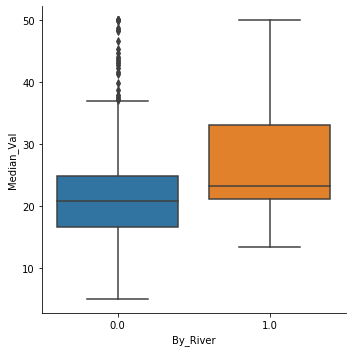

In [23]:
sns.catplot(x='By_River', y='Median_Val', kind='box', data=df)
# What do all the outliers mean

As we can see from the above counts and histogram, there are significantly more areas in our dataset that are located away from the Charles rive (471) vs next to the Charles River (35). There are also a significant number of outliers in the Median Value of houses in areas that are away from the river.

### Discuss issues with unequal sample sizes

Unequal sample sizes are a common issue that can lead to:
* Unequal variances between samples, which affects the assumption of equal variances in ANOVA Tests. 
* A general loss of power as equal size groups maxamize statistical power. This means it less likely the test will detect and effect if there is an effect to be detected.
* Issues with confounding variables.

However, while we need to be mindful of this it does not invalidate the results of an ANOVA test. 

In [24]:
next_to_river = df[df['By_River'] == 1]
away_from_river = df[df['By_River'] == 0]
next_to_river["Median_Val"].describe()

count    35.000000
mean     28.440000
std      11.816643
min      13.400000
25%      21.100000
50%      23.300000
75%      33.150000
max      50.000000
Name: Median_Val, dtype: float64

In [25]:
away_from_river["Median_Val"].describe()

count    471.000000
mean      22.093843
std        8.831362
min        5.000000
25%       16.600000
50%       20.900000
75%       24.800000
max       50.000000
Name: Median_Val, dtype: float64

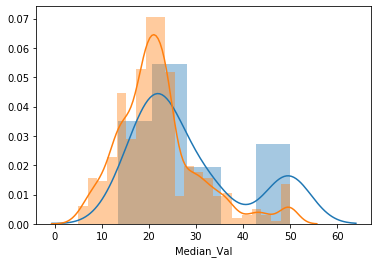

In [26]:
ax = sns.distplot(next_to_river['Median_Val'])
ax = sns.distplot(away_from_river['Median_Val'])
pyplt.rcParams["figure.figsize"] = (20,20)

### T-test

Before we can apply a T-Test, it first necessary to ensure that our datasets meet the requirements:

|#|Requirement|Pass|Reasoning|
|:------------------------|:---------|:-----------|:-----------|
|1|Dependent variable should be measured on continuous scale|YES|Median Value is measured on continuous scale|
|2|Independent variable should consist of two categorical independant groups|YES|Areas are either by or not by the river|
|3|Independence of observations|YES|None of the areas appear twice and no house appears in more than one area|
|4|There should be no significant outliers|NO|There are a number of outliers in the Median Values of houses not by the river|
|5|Dependent variable should be approximately normally distributed for each group|UNKNOWN|At first glance yes, but we will need to test to be sure|
|6|Needs to be homogeneity of variances|UNKNOWN|We will also need to test for this|


As you can see above, the first three requirements were met, but the 4th requirement was failed and the 5th and 6th requirements required further investigation before we can continue with out T-Test.

### Removing Outliers

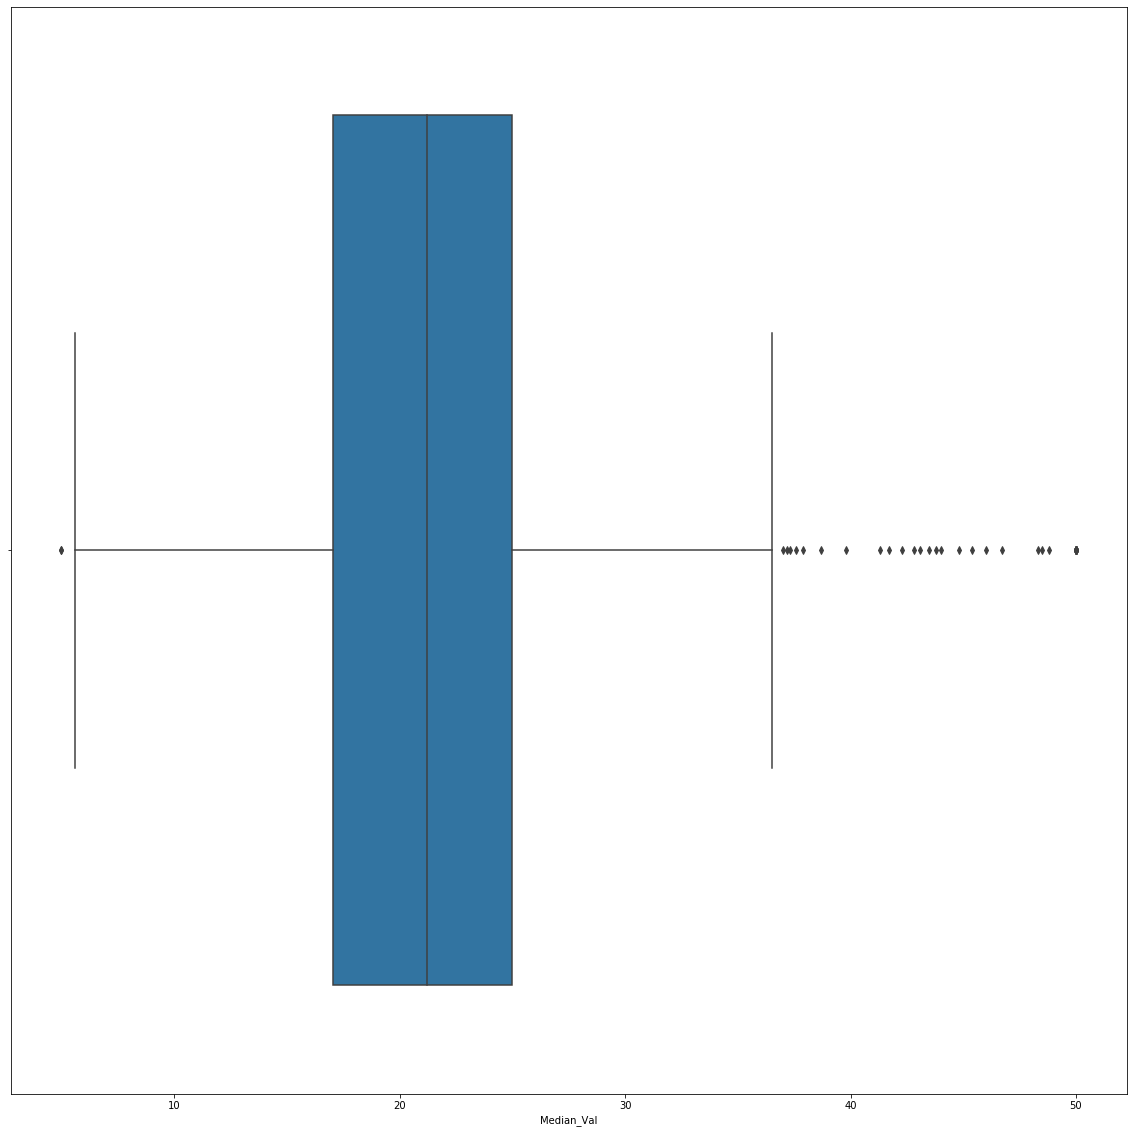

In [27]:
sns.boxplot(df['Median_Val'])

As we can see from the boxplot that we generated earlier there are a significant number of outliers in the target variable ("Median_Val"). There are also 16 areas where the median value of houses is $50,000. This indicates  that there might be a cap on values in the dataset at this value or that this value was entered where accurate information was not available. We could just remove these values, but first I will investigate how many outliers there are in total.

In order to identify the outliers we need to assign a threshold for the Median Value, above or below which we will consider the data point to be an outlier. The most obvious way of this is to follow the same method as the box-plot an remove an datapoints that are outside of the 75th and 25th percentiles. The Pandas library has a built in quantile method that can be used to calculate these thresholds.

In [28]:
Q1 = df['Median_Val'].quantile(0.25)
Q1

17.025

In [29]:
Q3 = df['Median_Val'].quantile(0.75)
Q3

25.0

In [30]:
IQR = Q3 - Q1
IQR

7.975000000000001

Now that the interquartile range has been calculated we can find the upper and lower "whisker" values for the box plot which will acts as our thresholds.

In [31]:
# calculate where the tip of the lower boxplot whisker is
lower_thresh = Q1 - 1.5 * IQR
lower_thresh

5.0624999999999964

In [32]:
# calculate where the tip of the upper boxplot whisker is
upper_thresh = Q3 + 1.5 * IQR
upper_thresh

36.962500000000006

In [33]:
# show all values that are below the lower outlier threshold
below = df.loc[df['Median_Val'] < lower_thresh]
below

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
398,38.3518,0.0,18.1,0.0,0.693,5.453,100.0,1.4896,24.0,666.0,20.2,396.90,30.59,5.0
405,67.9208,0.0,18.1,0.0,0.693,5.683,100.0,1.4254,24.0,666.0,20.2,384.97,22.98,5.0


There are two data points below the lower threshold.

In [34]:
# show all values that are above the upper outlier threshold
above = df.loc[df['Median_Val'] > upper_thresh]
above

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
97,0.12083,0.0,2.89,0.0,0.4450,8.069,76.0,3.4952,2.0,276.0,18.0,396.90,4.21,38.7
98,0.08187,0.0,2.89,0.0,0.4450,7.820,36.9,3.4952,2.0,276.0,18.0,393.53,3.57,43.8
157,1.22358,0.0,19.58,0.0,0.6050,6.943,97.4,1.8773,5.0,403.0,14.7,363.43,4.59,41.3
161,1.46336,0.0,19.58,0.0,0.6050,7.489,90.8,1.9709,5.0,403.0,14.7,374.43,1.73,50.0
162,1.83377,0.0,19.58,1.0,0.6050,7.802,98.2,2.0407,5.0,403.0,14.7,389.61,1.92,50.0
163,1.51902,0.0,19.58,1.0,0.6050,8.375,93.9,2.1620,5.0,403.0,14.7,388.45,3.32,50.0
166,2.01019,0.0,19.58,0.0,0.6050,7.929,96.2,2.0459,5.0,403.0,14.7,369.30,3.70,50.0
179,0.05780,0.0,2.46,0.0,0.4880,6.980,58.4,2.8290,3.0,193.0,17.8,396.90,5.04,37.2
180,0.06588,0.0,2.46,0.0,0.4880,7.765,83.3,2.7410,3.0,193.0,17.8,395.56,7.56,39.8
182,0.09103,0.0,2.46,0.0,0.4880,7.155,92.2,2.7006,3.0,193.0,17.8,394.12,4.82,37.9


In [35]:
above["Median_Val"].count()

38

There are 38 datapoints that are higher that the upper threshold. We can create a dataset called "no_outliers" that does not contain any outliers by removing both these groups.

In [36]:
no_outliers = df[((df['Median_Val'] > lower_thresh) & (df['Median_Val'] < upper_thresh))]
no_outliers

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
5,0.02985,0.0,2.18,0.0,0.458,6.430,58.7,6.0622,3.0,222.0,18.7,394.12,5.21,28.7
6,0.08829,12.5,7.87,0.0,0.524,6.012,66.6,5.5605,5.0,311.0,15.2,395.60,12.43,22.9
7,0.14455,12.5,7.87,0.0,0.524,6.172,96.1,5.9505,5.0,311.0,15.2,396.90,19.15,27.1
8,0.21124,12.5,7.87,0.0,0.524,5.631,100.0,6.0821,5.0,311.0,15.2,386.63,29.93,16.5
9,0.17004,12.5,7.87,0.0,0.524,6.004,85.9,6.5921,5.0,311.0,15.2,386.71,17.10,18.9


We can then compare what our two populations look like with the outliers removed.

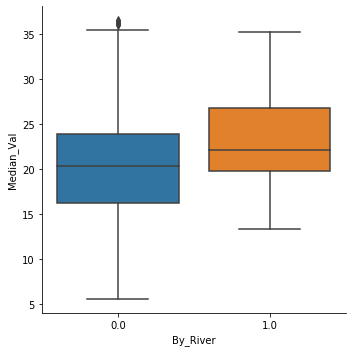

In [37]:

sns.catplot(x='By_River', y='Median_Val', kind='box', data=no_outliers)

### The dependant varibale needs to be approxmately normally distributed in each group.

In order to test this I created two new groups from the "no_outliers" dataset.

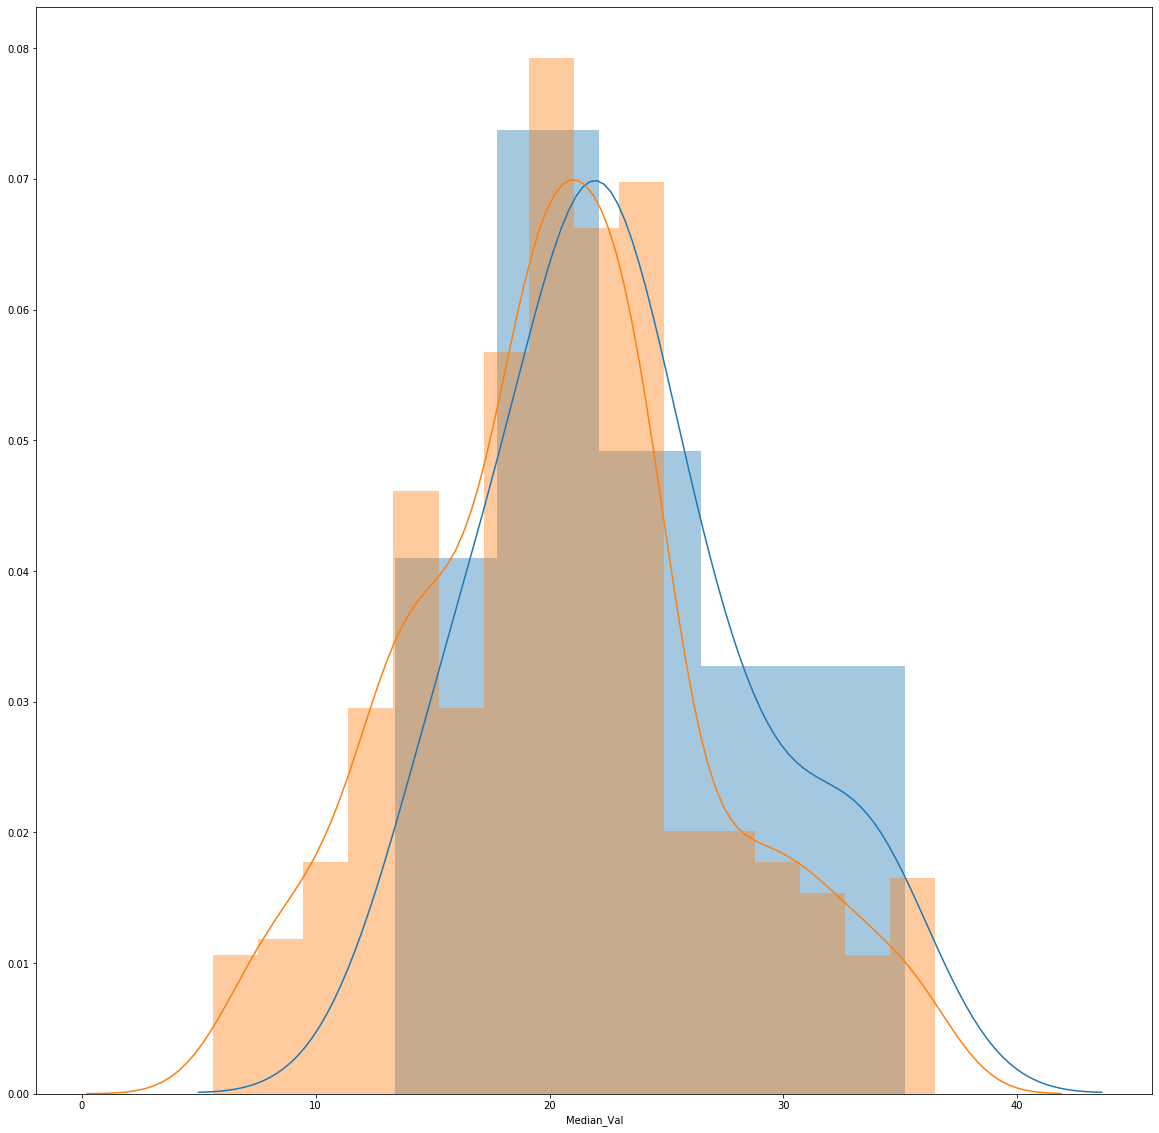

In [38]:
cleansed_next_to_river = no_outliers[no_outliers['By_River'] == 1]
cleansed_away_from_river = no_outliers[no_outliers['By_River'] == 0]

ax = sns.distplot(cleansed_next_to_river['Median_Val'])
ax = sns.distplot(cleansed_away_from_river['Median_Val'])
pyplt.rcParams["figure.figsize"] = (20,20)

From looking at the two "cleansed" datasets it can be observed that both are much closer to appearing to be normally distributed. However, we will need to test for this using Scipys "normaltest" function.

In [39]:
from scipy import stats
next_to_river_Ntest = stats.normaltest(cleansed_next_to_river['Median_Val'])
away_from_river_Ntest = stats.normaltest(cleansed_away_from_river['Median_Val'])
print(next_to_river_Ntest)
print(away_from_river_Ntest)


NormaltestResult(statistic=1.289316190319236, pvalue=0.5248419574390437)
NormaltestResult(statistic=3.405851916816045, pvalue=0.1821497808954563)


For both groups the Pvalue is greater than the alpha threshold(0.05). We can therefore say with a good degree of certainty that the data is normally distributed.
https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/

### Homogenity of Variances

Homogeneity of variance is an assumption underlying t tests in which the population variances (i.e., the distribution, or “spread,” of scores around the mean) of two or more samples are considered equal. In correlations and regressions, the term “homogeneity of variance in arrays,” also called “homoskedasticity,” refers to the assumption that, within the population, the variance of Y for each value of X is constant.

In order to perform a valid ttest we need to check if both samples have similar variances. Levenes test can be used to do this it. It tests the null hypothosis that variances are equal. 

In [40]:
# 
stats.levene(cleansed_next_to_river['Median_Val'], cleansed_away_from_river['Median_Val'])

LeveneResult(statistic=0.7964820987689898, pvalue=0.3726098479576784)

The Pvalue is greater than the threshold of 0.05 so we can say that there is no signifcant difference in the variances of both groups.

In [41]:
# variance of median values of houses next to the river
print(np.var(cleansed_next_to_river['Median_Val']))

31.402091836734694


In [42]:
# variance of values of house in areas away from the river
print(np.var(cleansed_away_from_river['Median_Val']))

41.76279086132484


### Summary of T Test Requirement Statuses

|#|Requirement|Pass|Reasoning|
|:------------------------|:---------|:-----------|:-----------|
|1|Dependent variable should be measured on continuous scale|YES|Median Value is measured on continuous scale|
|2|Independent variable should consist of two categorical independant groups|YES|Areas are either by or not by the river|
|3|Independence of observations|YES|None of the areas appear twice and no house appears in more than one area|
|4|There should be no significant outliers|YES|There were originally, but they have removed them.|
|5|Dependent variable should be approximately normally distributed for each group|YES|Both groups are approximately normally distrubuted.|
|6|Needs to be homogeneity of variances|YES|There is homogenity of variances|


### T Test Results

Since all the requirements were met, it was appropriate to proceed with the T Test.

In [43]:
stats.ttest_ind(cleansed_next_to_river['Median_Val'], cleansed_away_from_river['Median_Val'])

Ttest_indResult(statistic=2.100509858104912, pvalue=0.03622310352018016)

The purpose of the current study was to test if there is a significant difference in the Median_Value between the house prices in areas by or not by the Charles River in Boston.

In [44]:
import researchpy as rp

tt_descriptives, tt_results = rp.ttest(cleansed_next_to_river['Median_Val'], cleansed_away_from_river['Median_Val'])

tt_descriptives

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Median_Val,28.0,23.192857,5.706587,1.078444,20.980074,25.405640
1,Median_Val,438.0,20.560959,6.469804,0.309139,19.953375,21.168543
2,combined,466.0,20.719099,6.451416,0.298856,20.131823,21.306374


In [45]:
tt_results

,Independent t-test,results
0,Difference (Median_Val - Median_Val) =,2.6319
1,Degrees of freedom =,464.0000
2,t =,2.1005
3,Two side test p value =,0.0362
4,Difference > 0 p value =,0.9819
5,Difference < 0 p value =,0.0181
6,Cohen's d =,0.4095
7,Hedge's g =,0.4088
8,Glass's delta =,0.4612
9,r =,0.0971


The results of the test show a P value of 0.0362. This is lower than the 0.05 giving a strong indication that we can reject the null hypothesis that there is no difference between Median Value of houses in areas that are by or away from the Charles River in Boston. If the value was greater than 0.05 this would indicate that there was no difference between the two groups.

We can thereforce conclude that there is a significant difference between the housing prices for houses along the Charles River and those not along the Charles River.

# 4. Predictions


Add section discussiong the variables that were selected and why. 

What is the relationship between them all.

ANOVA Test?

## 4.1 Pre-Processing

Preprocessing is an integral step in Machine Learning. Quality of the data must be as good as possible before feeding into the model.

There are a number of different steps we can take to preprocesss the data and ensure the quality of the data:

1. Deal with any Null values
2. Deal with Categorical Variables
3. Standardise the Data


### 4.1.1 Null Values

First we will check to ensure if our cleansed dataset contains any Null values. If there are Null values, the row containing the value will be need to be removed of the value will need to be replaced.

In [46]:
no_outliers.isnull().sum()

Crime_Rate        0
%_Large_Plots     0
%_Indus           0
By_River          0
NOX               0
Rooms             0
%_Pre_1940        0
Dist_to_Jobs      0
Highway_Access    0
Tax               0
PTRatio           0
Blks_per_1000     0
%_Lower_Status    0
Median_Val        0
dtype: int64

As we can see, no of the columns contain Null values. So we can move on.

### 4.1.2 Check for Categorical Variables

As we have already seen there is one categorical variable in the dataset showing whether the area is located by or away from the Charles River.

Luckily this has already been coverted into a "dummy variable" of 0 for No and 1 for Yes. Therefore we dont have to do any encoding or processing of this variable.

In [47]:
no_outliers["By_River"]

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
501    0.0
502    0.0
503    0.0
504    0.0
505    0.0
Name: By_River, Length: 466, dtype: float64

### 4.1.3 Standardise the Data

In standardisation we transform all values such that the means of the values is 0 and the standard deviation is 1.

This helps to prevent a machine learning model from giving a different weight to values that are at a different scale to other values. For example, if we look at the below we can see that variables like the number of black people per 1000 is always going to be higher than the number of Rooms in a house or the Pupil Teacher Ratio.

In [48]:
no_outliers.head()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


Before we scale the data it needs to be split into the independent and dependent variables for the model.

It also a good idea to shuffle the data before going any further. 

In [49]:
no_outliers = shuffle(no_outliers)

In [50]:
# create the input from the first 13 variables
# output is the Median Value
x_input = no_outliers.iloc[:, 0:13]
y_output = no_outliers["Median_Val"]

The data then needs to be split into the testing and training sets. For this project we will use a 80:20 train:test split. 

We can use Sklearns model selection tool for this.

In [51]:
#train test splitting
x_train, x_test, y_train, y_test = mod.train_test_split(x_input, y_output, test_size=0.2)

In [52]:
x_train.iloc[0]

Crime_Rate          0.05372
%_Large_Plots       0.00000
%_Indus            13.92000
By_River            0.00000
NOX                 0.43700
Rooms               6.54900
%_Pre_1940         51.00000
Dist_to_Jobs        5.96040
Highway_Access      4.00000
Tax               289.00000
PTRatio            16.00000
Blks_per_1000     392.85000
%_Lower_Status      7.39000
Name: 296, dtype: float64

Once the data is split into testing and training sets it can be scaled.


In [53]:
scaler = pre.StandardScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train), columns=x_input.columns)
x_test = pd.DataFrame(scaler.transform(x_test), columns=x_input.columns)

In [54]:
x_train.iloc[0]

Crime_Rate       -0.466188
%_Large_Plots    -0.461906
%_Indus           0.319158
By_River         -0.244600
NOX              -1.054275
Rooms             0.671731
%_Pre_1940       -0.674622
Dist_to_Jobs      1.065733
Highway_Access   -0.668845
Tax              -0.748408
PTRatio          -1.329691
Blks_per_1000     0.420069
%_Lower_Status   -0.902210
Name: 0, dtype: float64

##  4.2 Baseline prediction test

At this stage I performed an inital test of the model to act as a performance baseline. I tuned this model further following this test.

In [55]:
# Defining the Baseline test model
m = ks.models.Sequential()
m.add(ks.layers.Dense(13, input_dim=13, activation="relu"))
m.add(ks.layers.Dense(1))
m.compile(loss="mean_squared_error", optimizer="adam")


Instructions for updating:
Colocations handled automatically by placer.


In [56]:
# why am I using these epochs and batch sizes
m.fit(x_train, y_train, epochs=100, batch_size=5)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
372/372 [==============================] - 0s 821us/step - loss: 442.7062
Epoch 2/100
372/372 [==============================] - 0s 301us/step - loss: 406.1127
Epoch 3/100
372/372 [==============================] - 0s 304us/step - loss: 367.2835
Epoch 4/100
372/372 [==============================] - 0s 320us/step - loss: 325.0754
Epoch 5/100
372/372 [==============================] - 0s 292us/step - loss: 281.6636
Epoch 6/100
372/372 [==============================] - 0s 272us/step - loss: 239.5934
Epoch 7/100
372/372 [==============================] - 0s 227us/step - loss: 199.8733
Epoch 8/100
372/372 [==============================] - 0s 213us/step - loss: 162.9042
Epoch 9/100
372/372 [==============================] - 0s 214us/step - loss: 128.4370
Epoch 10/100
372/372 [==============================] - 0s 241us/step - loss: 98.7437
Epoch 11/100
372/372 [==============================] - 0s 232us/step - loss: 76.1174
Epoch 

372/372 [==============================] - 0s 267us/step - loss: 5.7991
Epoch 94/100
372/372 [==============================] - 0s 255us/step - loss: 5.7772
Epoch 95/100
372/372 [==============================] - 0s 267us/step - loss: 5.7586
Epoch 96/100
372/372 [==============================] - 0s 244us/step - loss: 5.7598
Epoch 97/100
372/372 [==============================] - 0s 290us/step - loss: 5.7363
Epoch 98/100
372/372 [==============================] - 0s 280us/step - loss: 5.7132
Epoch 99/100
372/372 [==============================] - 0s 255us/step - loss: 5.7116
Epoch 100/100
372/372 [==============================] - 0s 267us/step - loss: 5.6584


In [57]:
# show the predicted prices for the test input variables
MedianVal_prediction = m.predict(x_test).T
MedianVal_prediction

array([[21.28017 , 29.699352, 27.765327, 20.43001 , 17.87085 , 16.61673 ,
        22.38565 , 19.678635, 25.662167, 30.14817 , 18.238419, 10.096915,
        23.441025, 30.785978, 30.420612, 19.518494,  9.745989, 23.42093 ,
        27.63683 , 26.540129, 24.159214, 22.593462, 19.306334, 15.519169,
        25.09367 , 18.439135, 16.1078  , 23.09935 , 19.985558, 11.056583,
        20.751402, 18.055614, 14.612111, 22.701492, 13.788042, 22.378145,
        25.672916, 24.218712, 28.51279 , 32.898876, 23.381956, 30.718796,
        23.803051, 27.981724, 24.478739, 11.089801, 10.726618, 14.993631,
        29.421772, 21.19773 , 24.52537 , 25.139082, 33.544823, 24.822718,
        23.391659, 13.267127, 15.486575, 13.325727, 29.802208, 13.352875,
        16.22359 , 24.877071, 23.512705, 31.075256, 25.535799, 23.689531,
        22.684408, 20.96902 , 20.420553, 24.29351 , 33.732555, 27.69086 ,
        23.027138, 28.032406, 23.581352, 14.460633, 19.57079 , 22.109785,
        16.916012, 10.560457, 18.04123

In [58]:
#show the real values
MedianVal_real = y_test.as_matrix().astype(np.float32)
MedianVal_real

c:\users\conor\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


array([19.4, 29.1, 31.5, 17.4, 23.7, 15.3, 21.2, 19.4, 22. , 33.1, 19.9,
       13.4, 27.5, 34.9, 31.6, 16.2,  7.2, 25. , 29.4, 36.2, 28.1, 23.8,
       18.8, 15.6, 24.7, 18.2, 15.6, 22.2, 24.3, 10.4, 20.9, 13.8, 13.1,
       21.9, 15.6, 22.2, 22.6, 23.4, 34.9, 34.9, 23.1, 36.4, 23.2, 24.8,
       20.7,  8.4,  8.1, 14.1, 31.5, 18.7, 22.1, 24.8, 31. , 25. , 16.5,
       11.9, 13.3, 13.6, 31.7, 12.3, 12.5, 30.1, 23.4, 33.4, 24.6, 23.2,
       11.9, 24.3, 19.2, 22.9, 33.3, 26.6, 24.1, 28. , 23.7, 14.5, 21.8,
       21.7, 17. , 10.2, 21.4, 26.5, 14.4, 10.5, 17.8, 22.6, 29.8, 14.1,
       21. , 21.5, 13.1, 21.7, 23.1, 19.6], dtype=float32)

In [59]:
# Show prediction vs real side by side with difference between the two
predicted_V_real_df = pd.DataFrame({'Prediction': MedianVal_prediction.ravel(), 'Real_value': MedianVal_real.ravel()})
predicted_V_real_df['%Difference'] = 100*(abs(predicted_V_real_df['Prediction'] - predicted_V_real_df['Real_value'])/predicted_V_real_df['Prediction'])
predicted_V_real_df

,Prediction,Real_value,%Difference
0,21.280170,19.400000,8.835319
1,29.699352,29.100000,2.018064
2,27.765327,31.500000,13.450850
3,20.430010,17.400000,14.831173
4,17.870850,23.700001,32.618210
5,16.616730,15.300000,7.924119
6,22.385651,21.200001,5.296473
7,19.678635,19.400000,1.415927
8,25.662167,22.000000,14.270684
9,30.148170,33.099998,9.791069


In [60]:
# average of the percentage difference
predicted_V_real_df['%Difference'].mean()

10.374252

In [61]:
# Evaluate the accuracy 
m.evaluate(x_test, y_test)

94/94 [==============================] - 0s 525us/step


8.308961350867088

## 4.3 Factor to Consider When Creating a Model

Before going any further it is worth outlining my reasoning for selecting the options that I did when creating this Baseline model and considerations for improving the model in later iterations.

#### Model Selection

I used the Sequential Model. This is "default" model for Keras. It functions by adding sequential layers of neurons. Inputs are fed into the first layers with outputs being passed on to subsequent layers. 

In the Baseline Test I have just added an input later that takes in 13 variables, and an output layers that gives out a single values (Y).

There is also the option to create custom "functional models" in Keras, but this was not necessary what we are trying to achieve.

#### Density

This is the layer type. In this type all node/neurons in the next layer are connected to all nodes in the previous layer. This is the best layer type for this projects use case. However, other layer types exist, such as Convolutional Layers (used for image prediction) and Recurrent Layers (used for time series data). 

#### Number of Layers

For the baseline we have added 1 input later and 1 output layer. This is the absolute minimum number we can have. There is also an single "hidden layer" automatically created from the outputs of the input layer.

In the case of linear and generalized linear models , having no hidden layers is enough and increasing this number doesn't necessarily improve the performance of the model. However, if there are mutliple inputs (such as in our data) having up to 2 hidden layers can help to improve accuracy, but there is no set rules for what will deliver the best results. [1][2]. 

I will introduce additional layers in later iterations of the model.

#### Number of Units per Layer

The number of input units should match the number of variables being inputted while the number of output units should match the number of outputs required. In this case we have 13 input variables and required 1 output. This is what has been entered into the Baseline test.

The number of units in a hidden layer depends on a number of factors [3]:

* the numbers of input and output units 
* the number of training cases 
* the amount of noise in the targets 
* the complexity of the function or classification to be learned 
* the architecture 
* the type of hidden unit activation function 
* the training algorithm 
* regularization 
 
Having too few or too many hidden units can result in underfitting and overfitting respectively reducing accuracy. 

There are some rules of thumb such as:
* somewhere between the size of the input and output layer
* (inputs + outputs) x 2/3
* never more than twice the number of the input layer

These fail to take account of size of the training dataset and other considerations [3]. 

We will expriment with different unit sizes in later iterations.



#### Activation Function

Choosing an appropriate activation function is one of the most important considerations when designing a model. An activation function is the non-linear transformation that is performed on the input data to create the output. In the absense of an activation function the model is just a linear regression model[4].

Different activation functions have different use cases. For example, Binary Step Functions is used in classification where there are only two choices. This is obviously not suitable for this projects dataset, but there are several others that are worth considering. 

##### Linear 
* Assumes input is proportional to output 
* Only suitable for simple tasks as each layer in the model only does a linear transformation of the output of the previous layer and passes it on.
* This is also the default function in Keras if no other function is specified.

##### Sigmoid 
* Non-linear
* Tries to push Y values to extremes making it useful for classification

##### Tanh 
* Essentially a scalled version of the Sigmoid function

##### ReLU
* The most widely used activation function.
* Full name is Rectified Linear Unit
* It's non-linear allowing for back propigation of erros. 
* Allows for mutliple layers of activated by the ReLU function. 
* ReLu should only be used in hidden layers.

As a rule of thumb, ReLu should be the first port of call when creating a model. If it's results are not optimal, then other functions can be considered [7]. This is why ReLU was used in the Baseline Model. The output was left at the default linear function. 




#### Loss Function

This is the method used to find the error between the actual values and predicted value. Different metrics are used for different use cases. 

For regression problems the best option is "mean-squared error" [6].

#### Optimizer

Optimizers try to minimise the loss function and make predictions as correct as possible. They do this by updating the model in response to the output of the loss function[10]. 

Adam is generally recommended as the best optimizer to use [8] along with SGD using Nestorov momentum[9]. I have used Adam in the baseline model and given that Adam incorporates many of the good features of SGD I do not think there would be much value in using other optimizers.

#### Epochs

An epoch is single pass of the entire training dataset through a machine learning model.

One pass is not enough as the model is learning each time the model is passed through. If there are too many epochs the model will go from underfitting to overfitting. That being said, there is no fixed rule on how many epochs is best for a given dataset [11]. 

In our Baseline Model we have set the model to perform 100 epochs. We will try larger numbers of epochs in later iterations. 

#### Batch Size

The batch size is the number of samples processed before the model is updated. For example, in the Baseline Model the batch size is 5. There are 372 samples (rows) in the training dataset so the date will be divided into 74 batches each with 5 rows. Therefore each epoch will involved 74 updates to the model. 

Generally, batch sizes are set to values that are to the power of 2 e.g. 32, 64, 128 etc. A good default batch size is 32 with smaller batches tending to give better results [12]. 


## 4.4 Model Tuning - Round 1

I will now test updating the model based on some of the possible improvements discussed above

1. Decreasing batch sizes beginning at 32
2. Increasing number of epochs starting at 100
3. Varied Layer Sizes
4. Increased numbers of layers

I will not be changing:
1. Activation functions
2. Loss function
3. Optimizer
From my investigation, the options in the Baseline Model already seem to be the best fit for the dataset.

### 4.4.1 Batch Sizes

###### Test 1-  Increasing Batch Size to 32


In [62]:
# Test 1
m = ks.models.Sequential()
m.add(ks.layers.Dense(13, input_dim=13, activation="relu"))
m.add(ks.layers.Dense(1))

m.compile(loss="mean_squared_error", optimizer="adam")

m.fit(x_train, y_train, epochs=100, batch_size=32)

batch_test1_prediction = m.predict(x_test).T

MedianVal_real = y_test.as_matrix().astype(np.float32)

result_batch1 = m.evaluate(x_test, y_test)

Epoch 1/100
372/372 [==============================] - 0s 564us/step - loss: 446.2575
Epoch 2/100
372/372 [==============================] - 0s 101us/step - loss: 438.3365
Epoch 3/100
372/372 [==============================] - 0s 84us/step - loss: 430.2314
Epoch 4/100
372/372 [==============================] - 0s 53us/step - loss: 422.1978
Epoch 5/100
372/372 [==============================] - 0s 43us/step - loss: 413.9129
Epoch 6/100
372/372 [==============================] - 0s 46us/step - loss: 405.4317
Epoch 7/100
372/372 [==============================] - 0s 56us/step - loss: 396.5445
Epoch 8/100
372/372 [==============================] - 0s 49us/step - loss: 387.5147
Epoch 9/100
372/372 [==============================] - 0s 52us/step - loss: 378.1073
Epoch 10/100
372/372 [==============================] - 0s 42us/step - loss: 368.4627
Epoch 11/100
372/372 [==============================] - 0s 49us/step - loss: 358.5551
Epoch 12/100
372/372 [==============================] - 0s 47

372/372 [==============================] - 0s 53us/step - loss: 19.1437
Epoch 98/100
372/372 [==============================] - 0s 36us/step - loss: 18.9224
Epoch 99/100
372/372 [==============================] - 0s 38us/step - loss: 18.7224
Epoch 100/100
94/94 [==============================] - 0s 500us/step


c:\users\conor\anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


In [63]:
result_batch1

23.520692094843437

###### Test 2 - Batch Size to 16

In [64]:
# Test 2
m = ks.models.Sequential()
m.add(ks.layers.Dense(13, input_dim=13, activation="relu"))
m.add(ks.layers.Dense(1))

m.compile(loss="mean_squared_error", optimizer="adam")

m.fit(x_train, y_train, epochs=100, batch_size=16)

batch_test1_prediction = m.predict(x_test).T

MedianVal_real = y_test.as_matrix().astype(np.float32)

result_batch2 = m.evaluate(x_test, y_test)

Epoch 1/100
372/372 [==============================] - 0s 604us/step - loss: 442.3215
Epoch 2/100
372/372 [==============================] - 0s 97us/step - loss: 428.1480
Epoch 3/100
372/372 [==============================] - 0s 97us/step - loss: 412.8508
Epoch 4/100
372/372 [==============================] - 0s 95us/step - loss: 396.0778
Epoch 5/100
372/372 [==============================] - 0s 105us/step - loss: 377.8144
Epoch 6/100
372/372 [==============================] - 0s 102us/step - loss: 358.1073
Epoch 7/100
372/372 [==============================] - 0s 95us/step - loss: 336.7227
Epoch 8/100
372/372 [==============================] - 0s 86us/step - loss: 315.1264
Epoch 9/100
372/372 [==============================] - 0s 92us/step - loss: 293.1542
Epoch 10/100
372/372 [==============================] - 0s 102us/step - loss: 270.5158
Epoch 11/100
372/372 [==============================] - 0s 113us/step - loss: 247.4000
Epoch 12/100
372/372 [==============================] - 0s

Epoch 97/100
372/372 [==============================] - 0s 97us/step - loss: 10.8571
Epoch 98/100
372/372 [==============================] - 0s 93us/step - loss: 10.7717
Epoch 99/100
372/372 [==============================] - 0s 98us/step - loss: 10.6823
Epoch 100/100
94/94 [==============================] - 0s 1ms/step


c:\users\conor\anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


In [65]:
result_batch2

16.69866446231274

###### Test 3 - Batch Size to 4

In [66]:
# Test 3
m = ks.models.Sequential()
m.add(ks.layers.Dense(13, input_dim=13, activation="relu"))
m.add(ks.layers.Dense(1))

m.compile(loss="mean_squared_error", optimizer="adam")

m.fit(x_train, y_train, epochs=100, batch_size=4)

batch_test1_prediction = m.predict(x_test).T

MedianVal_real = y_test.as_matrix().astype(np.float32)

result_batch3 = m.evaluate(x_test, y_test)

Epoch 1/100
372/372 [==============================] - 0s 826us/step - loss: 415.7606
Epoch 2/100
372/372 [==============================] - 0s 325us/step - loss: 364.9704
Epoch 3/100
372/372 [==============================] - 0s 325us/step - loss: 298.1288
Epoch 4/100
372/372 [==============================] - 0s 349us/step - loss: 223.3518
Epoch 5/100
372/372 [==============================] - 0s 304us/step - loss: 155.8404
Epoch 6/100
372/372 [==============================] - 0s 346us/step - loss: 105.2179
Epoch 7/100
372/372 [==============================] - 0s 340us/step - loss: 72.9210
Epoch 8/100
372/372 [==============================] - 0s 331us/step - loss: 53.3485
Epoch 9/100
372/372 [==============================] - 0s 309us/step - loss: 40.4717
Epoch 10/100
372/372 [==============================] - 0s 311us/step - loss: 31.4903
Epoch 11/100
372/372 [==============================] - 0s 332us/step - loss: 25.3609
Epoch 12/100
372/372 [==============================] - 0

372/372 [==============================] - 0s 339us/step - loss: 5.8536
Epoch 98/100
372/372 [==============================] - 0s 340us/step - loss: 5.9164
Epoch 99/100
372/372 [==============================] - 0s 335us/step - loss: 5.8491
Epoch 100/100
94/94 [==============================] - 0s 1ms/step


c:\users\conor\anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


In [67]:
result_batch3

8.63398985152549

###### Test 4 - Batch Size to 2

In [68]:
# Test 4
m = ks.models.Sequential()
m.add(ks.layers.Dense(13, input_dim=13, activation="relu"))
m.add(ks.layers.Dense(1))

m.compile(loss="mean_squared_error", optimizer="adam")

m.fit(x_train, y_train, epochs=100, batch_size=2)

batch_test1_prediction = m.predict(x_test).T

MedianVal_real = y_test.as_matrix().astype(np.float32)

result_batch4 = m.evaluate(x_test, y_test)

Epoch 1/100
372/372 [==============================] - 0s 1ms/step - loss: 442.3162
Epoch 2/100
372/372 [==============================] - 0s 683us/step - loss: 370.9128
Epoch 3/100
372/372 [==============================] - 0s 654us/step - loss: 277.7454
Epoch 4/100
372/372 [==============================] - 0s 673us/step - loss: 171.6601
Epoch 5/100
372/372 [==============================] - 0s 719us/step - loss: 92.6356
Epoch 6/100
372/372 [==============================] - 0s 764us/step - loss: 55.2341
Epoch 7/100
372/372 [==============================] - 0s 709us/step - loss: 38.8804
Epoch 8/100
372/372 [==============================] - 0s 644us/step - loss: 29.8289
Epoch 9/100
372/372 [==============================] - 0s 689us/step - loss: 23.9120
Epoch 10/100
372/372 [==============================] - 0s 691us/step - loss: 19.8486
Epoch 11/100
372/372 [==============================] - 0s 668us/step - loss: 17.2759
Epoch 12/100
372/372 [==============================] - 0s 66

372/372 [==============================] - 0s 650us/step - loss: 5.1372
Epoch 97/100
372/372 [==============================] - 0s 550us/step - loss: 5.1028
Epoch 98/100
372/372 [==============================] - 0s 578us/step - loss: 5.1573
Epoch 99/100
372/372 [==============================] - 0s 713us/step - loss: 5.1779
Epoch 100/100
94/94 [==============================] - 0s 869us/step


c:\users\conor\anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


In [69]:
result_batch4

9.176860190452413

#### 4.4.1.1 Commentary

I tested batch sizes multiple times and the results for 2 vs 4 batches was inconclusive. Sometimes 2 performed better and sometimes 4 performed better.

In order to get a more conclusive answer I test each five times and got the average of the tests.

In [91]:
# function to test batch sizes with 10 test and average of results

def batchsize_test(tests, b_size):
    counter = 0
    resultslist = []
    while counter < tests:
        m = ks.models.Sequential()
        m.add(ks.layers.Dense(13, input_dim=13, activation="relu"))
        m.add(ks.layers.Dense(1))

        m.compile(loss="mean_squared_error", optimizer="adam")

        m.fit(x_train, y_train, epochs=100, batch_size=b_size)

        batch_test1_prediction = m.predict(x_test).T

        MedianVal_real = y_test.as_matrix().astype(np.float32)

        result_batch3 = m.evaluate(x_test, y_test)
        counter += 1
        resultslist.append(result_batch3)
    avg_result = sum(resultslist) / tests
    return avg_result

print(batchsize_test(5, 2))

Epoch 1/100
372/372 [==============================] - 2s 5ms/step - loss: 413.0415
Epoch 2/100
372/372 [==============================] - 1s 1ms/step - loss: 360.7371
Epoch 3/100
372/372 [==============================] - 0s 1ms/step - loss: 291.0159
Epoch 4/100
372/372 [==============================] - 0s 914us/step - loss: 218.6003
Epoch 5/100
372/372 [==============================] - 0s 836us/step - loss: 156.9405
Epoch 6/100
372/372 [==============================] - 0s 921us/step - loss: 112.3883
Epoch 7/100
372/372 [==============================] - 1s 1ms/step - loss: 81.7340
Epoch 8/100
372/372 [==============================] - 1s 1ms/step - loss: 59.7777
Epoch 9/100
372/372 [==============================] - 0s 1ms/step - loss: 44.1737
Epoch 10/100
372/372 [==============================] - 0s 786us/step - loss: 33.5479
Epoch 11/100
372/372 [==============================] - 0s 1ms/step - loss: 26.6477
Epoch 12/100
372/372 [==============================] - 0s 1ms/step - l

372/372 [==============================] - 0s 657us/step - loss: 5.7841
Epoch 99/100
372/372 [==============================] - 0s 825us/step - loss: 5.7161
Epoch 100/100
372/372 [==============================] - 0s 1ms/step - loss: 5.6823


c:\users\conor\anaconda3\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


94/94 [==============================] - 1s 15ms/step
Epoch 1/100
372/372 [==============================] - 2s 5ms/step - loss: 397.6699
Epoch 2/100
372/372 [==============================] - 0s 858us/step - loss: 344.7971
Epoch 3/100
372/372 [==============================] - 0s 829us/step - loss: 280.6855
Epoch 4/100
372/372 [==============================] - 0s 800us/step - loss: 211.0240
Epoch 5/100
372/372 [==============================] - 0s 1ms/step - loss: 145.8506
Epoch 6/100
372/372 [==============================] - 0s 1ms/step - loss: 92.7100
Epoch 7/100
372/372 [==============================] - 0s 1ms/step - loss: 57.2173
Epoch 8/100
372/372 [==============================] - 0s 1ms/step - loss: 37.7795
Epoch 9/100
372/372 [==============================] - 0s 1ms/step - loss: 28.0854
Epoch 10/100
372/372 [==============================] - 0s 1ms/step - loss: 22.9445
Epoch 11/100
372/372 [==============================] - 0s 1ms/step - loss: 19.8685
Epoch 12/100
372/372

372/372 [==============================] - 0s 615us/step - loss: 5.2629
Epoch 98/100
372/372 [==============================] - 0s 698us/step - loss: 5.2728
Epoch 99/100
372/372 [==============================] - 0s 675us/step - loss: 5.2081
Epoch 100/100
94/94 [==============================] - 1s 14ms/step
Epoch 1/100
372/372 [==============================] - 2s 5ms/step - loss: 416.2220
Epoch 2/100
372/372 [==============================] - 0s 741us/step - loss: 365.0843
Epoch 3/100
372/372 [==============================] - 0s 674us/step - loss: 299.5130
Epoch 4/100
372/372 [==============================] - 0s 1ms/step - loss: 226.2786
Epoch 5/100
372/372 [==============================] - 0s 1ms/step - loss: 157.3159
Epoch 6/100
372/372 [==============================] - 1s 1ms/step - loss: 102.7592
Epoch 7/100
372/372 [==============================] - 1s 1ms/step - loss: 66.3795
Epoch 8/100
372/372 [==============================] - 1s 1ms/step - loss: 45.0136
Epoch 9/100
372/

372/372 [==============================] - 0s 812us/step - loss: 5.5286
Epoch 94/100
372/372 [==============================] - 0s 789us/step - loss: 5.5596
Epoch 95/100
372/372 [==============================] - 0s 791us/step - loss: 5.5477
Epoch 96/100
372/372 [==============================] - 0s 1ms/step - loss: 5.4795
Epoch 97/100
372/372 [==============================] - 0s 761us/step - loss: 5.5229
Epoch 98/100
372/372 [==============================] - 0s 703us/step - loss: 5.5223
Epoch 99/100
372/372 [==============================] - 0s 812us/step - loss: 5.4648
Epoch 100/100
94/94 [==============================] - 1s 14ms/step
Epoch 1/100
372/372 [==============================] - 2s 5ms/step - loss: 418.8540
Epoch 2/100
372/372 [==============================] - 1s 1ms/step - loss: 367.2515
Epoch 3/100
372/372 [==============================] - 0s 1ms/step - loss: 302.1916
Epoch 4/100
372/372 [==============================] - 0s 1ms/step - loss: 227.9069
Epoch 5/100
372/

372/372 [==============================] - 1s 1ms/step - loss: 5.8179
Epoch 89/100
372/372 [==============================] - 1s 1ms/step - loss: 5.7913
Epoch 90/100
372/372 [==============================] - 1s 1ms/step - loss: 5.7841
Epoch 91/100
372/372 [==============================] - 1s 1ms/step - loss: 5.7928
Epoch 92/100
372/372 [==============================] - 1s 2ms/step - loss: 5.7402
Epoch 93/100
372/372 [==============================] - 1s 1ms/step - loss: 5.7189
Epoch 94/100
372/372 [==============================] - 1s 2ms/step - loss: 5.6920
Epoch 95/100
372/372 [==============================] - 0s 1ms/step - loss: 5.7086
Epoch 96/100
372/372 [==============================] - 0s 1ms/step - loss: 5.6643
Epoch 97/100
372/372 [==============================] - 0s 978us/step - loss: 5.6460
Epoch 98/100
372/372 [==============================] - 0s 877us/step - loss: 5.7037
Epoch 99/100
372/372 [==============================] - 0s 887us/step - loss: 5.6017
Epoch 100/1

372/372 [==============================] - 0s 1ms/step - loss: 5.6951
Epoch 85/100
372/372 [==============================] - 0s 1ms/step - loss: 5.6754
Epoch 86/100
372/372 [==============================] - 0s 1ms/step - loss: 5.6763
Epoch 87/100
372/372 [==============================] - 1s 1ms/step - loss: 5.6305
Epoch 88/100
372/372 [==============================] - 0s 1ms/step - loss: 5.5927
Epoch 89/100
372/372 [==============================] - 0s 803us/step - loss: 5.6202
Epoch 90/100
372/372 [==============================] - 0s 786us/step - loss: 5.5656
Epoch 91/100
372/372 [==============================] - 0s 808us/step - loss: 5.5063
Epoch 92/100
372/372 [==============================] - 0s 807us/step - loss: 5.5276
Epoch 93/100
372/372 [==============================] - 0s 990us/step - loss: 5.5395
Epoch 94/100
372/372 [==============================] - 0s 1ms/step - loss: 5.4710
Epoch 95/100
372/372 [==============================] - 0s 1ms/step - loss: 5.4855
Epoch 9

372/372 [==============================] - 1s 3ms/step - loss: 5.2474
Epoch 82/100
372/372 [==============================] - 1s 2ms/step - loss: 5.2255
Epoch 83/100
372/372 [==============================] - 1s 3ms/step - loss: 5.2108
Epoch 84/100
372/372 [==============================] - 1s 2ms/step - loss: 5.2079
Epoch 85/100
372/372 [==============================] - 1s 3ms/step - loss: 5.1030
Epoch 86/100
372/372 [==============================] - 1s 2ms/step - loss: 5.1501
Epoch 87/100
372/372 [==============================] - 1s 2ms/step - loss: 5.1269
Epoch 88/100
372/372 [==============================] - 1s 2ms/step - loss: 5.1109
Epoch 89/100
372/372 [==============================] - 1s 2ms/step - loss: 5.1198
Epoch 90/100
372/372 [==============================] - 1s 2ms/step - loss: 5.0535
Epoch 91/100
372/372 [==============================] - 1s 2ms/step - loss: 4.9794
Epoch 92/100
372/372 [==============================] - 1s 2ms/step - loss: 5.0031
Epoch 93/100
372/

372/372 [==============================] - 1s 3ms/step - loss: 5.2597
Epoch 80/100
372/372 [==============================] - 1s 3ms/step - loss: 5.1585
Epoch 81/100
372/372 [==============================] - 1s 3ms/step - loss: 5.2188
Epoch 82/100
372/372 [==============================] - 1s 3ms/step - loss: 5.1533
Epoch 83/100
372/372 [==============================] - 1s 3ms/step - loss: 5.2242
Epoch 84/100
372/372 [==============================] - 1s 3ms/step - loss: 5.1957
Epoch 85/100
372/372 [==============================] - 1s 2ms/step - loss: 5.1545
Epoch 86/100
372/372 [==============================] - 1s 2ms/step - loss: 5.1793
Epoch 87/100
372/372 [==============================] - 1s 3ms/step - loss: 5.2138
Epoch 88/100
372/372 [==============================] - 1s 3ms/step - loss: 5.1356
Epoch 89/100
372/372 [==============================] - 1s 2ms/step - loss: 5.1375
Epoch 90/100
372/372 [==============================] - 1s 2ms/step - loss: 5.1025
Epoch 91/100
372/

372/372 [==============================] - 1s 1ms/step - loss: 5.2293
Epoch 78/100
372/372 [==============================] - 1s 3ms/step - loss: 5.2425
Epoch 79/100
372/372 [==============================] - 1s 2ms/step - loss: 5.1603
Epoch 80/100
372/372 [==============================] - 1s 2ms/step - loss: 5.1768
Epoch 81/100
372/372 [==============================] - 1s 1ms/step - loss: 5.1224
Epoch 82/100
372/372 [==============================] - 1s 2ms/step - loss: 5.1460
Epoch 83/100
372/372 [==============================] - 1s 2ms/step - loss: 5.1648
Epoch 84/100
372/372 [==============================] - 1s 2ms/step - loss: 5.1420
Epoch 85/100
372/372 [==============================] - 1s 2ms/step - loss: 5.0925
Epoch 86/100
372/372 [==============================] - 1s 2ms/step - loss: 5.1509
Epoch 87/100
372/372 [==============================] - 1s 2ms/step - loss: 5.0938
Epoch 88/100
372/372 [==============================] - 1s 3ms/step - loss: 5.0998
Epoch 89/100
372/

372/372 [==============================] - 1s 2ms/step - loss: 5.1368
Epoch 75/100
372/372 [==============================] - 1s 3ms/step - loss: 5.1545
Epoch 76/100
372/372 [==============================] - 1s 3ms/step - loss: 5.1094
Epoch 77/100
372/372 [==============================] - 1s 2ms/step - loss: 5.1663
Epoch 78/100
372/372 [==============================] - 1s 2ms/step - loss: 5.0392
Epoch 79/100
372/372 [==============================] - 1s 2ms/step - loss: 5.1367
Epoch 80/100
372/372 [==============================] - 1s 3ms/step - loss: 5.0542
Epoch 81/100
372/372 [==============================] - 1s 2ms/step - loss: 5.0174
Epoch 82/100
372/372 [==============================] - 1s 2ms/step - loss: 5.0305
Epoch 83/100
372/372 [==============================] - 1s 2ms/step - loss: 4.9467
Epoch 84/100
372/372 [==============================] - 1s 3ms/step - loss: 4.9937
Epoch 85/100
372/372 [==============================] - 1s 2ms/step - loss: 4.9562
Epoch 86/100
372/

372/372 [==============================] - 1s 2ms/step - loss: 5.5356
Epoch 73/100
372/372 [==============================] - 1s 2ms/step - loss: 5.4264
Epoch 74/100
372/372 [==============================] - 1s 2ms/step - loss: 5.4166
Epoch 75/100
372/372 [==============================] - 1s 3ms/step - loss: 5.3515
Epoch 76/100
372/372 [==============================] - 1s 2ms/step - loss: 5.3574
Epoch 77/100
372/372 [==============================] - 1s 2ms/step - loss: 5.2806
Epoch 78/100
372/372 [==============================] - 1s 2ms/step - loss: 5.3122
Epoch 79/100
372/372 [==============================] - 1s 2ms/step - loss: 5.2564
Epoch 80/100
372/372 [==============================] - 1s 2ms/step - loss: 5.2407
Epoch 81/100
372/372 [==============================] - 1s 2ms/step - loss: 5.2512
Epoch 82/100
372/372 [==============================] - 1s 2ms/step - loss: 5.1912
Epoch 83/100
372/372 [==============================] - 1s 2ms/step - loss: 5.0971
Epoch 84/100
372/

In [92]:
print(batchsize_test(5, 4))

Epoch 1/100
372/372 [==============================] - 2s 6ms/step - loss: 442.7523
Epoch 2/100
372/372 [==============================] - 0s 893us/step - loss: 391.4470
Epoch 3/100
372/372 [==============================] - 0s 821us/step - loss: 331.8392
Epoch 4/100
372/372 [==============================] - 0s 817us/step - loss: 264.3865
Epoch 5/100
372/372 [==============================] - 0s 845us/step - loss: 200.3869
Epoch 6/100
372/372 [==============================] - 0s 819us/step - loss: 148.5159
Epoch 7/100
372/372 [==============================] - 0s 1ms/step - loss: 110.0643
Epoch 8/100
372/372 [==============================] - 1s 1ms/step - loss: 82.2250
Epoch 9/100
372/372 [==============================] - 1s 2ms/step - loss: 61.7229
Epoch 10/100
372/372 [==============================] - 0s 1ms/step - loss: 46.7723
Epoch 11/100
372/372 [==============================] - 0s 1ms/step - loss: 36.3710
Epoch 12/100
372/372 [==============================] - 0s 943us/ste

372/372 [==============================] - 0s 1ms/step - loss: 5.4308
Epoch 98/100
372/372 [==============================] - 0s 1ms/step - loss: 5.4285
Epoch 99/100
372/372 [==============================] - 0s 875us/step - loss: 5.4060
Epoch 100/100
372/372 [==============================] - 0s 848us/step - loss: 5.3733


c:\users\conor\anaconda3\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


94/94 [==============================] - 2s 18ms/step
Epoch 1/100
372/372 [==============================] - 2s 5ms/step - loss: 454.6458
Epoch 2/100
372/372 [==============================] - 1s 1ms/step - loss: 417.4389
Epoch 3/100
372/372 [==============================] - 0s 1ms/step - loss: 373.5099
Epoch 4/100
372/372 [==============================] - 0s 1ms/step - loss: 320.4352
Epoch 5/100
372/372 [==============================] - 0s 1ms/step - loss: 259.5860
Epoch 6/100
372/372 [==============================] - 0s 1ms/step - loss: 197.5808
Epoch 7/100
372/372 [==============================] - 0s 1ms/step - loss: 142.4928
Epoch 8/100
372/372 [==============================] - 0s 909us/step - loss: 100.4725
Epoch 9/100
372/372 [==============================] - 0s 1ms/step - loss: 72.2845
Epoch 10/100
372/372 [==============================] - 1s 2ms/step - loss: 54.9102
Epoch 11/100
372/372 [==============================] - 1s 1ms/step - loss: 44.1917
Epoch 12/100
372/372 

372/372 [==============================] - 0s 730us/step - loss: 5.5928
Epoch 98/100
372/372 [==============================] - 0s 827us/step - loss: 5.5688
Epoch 99/100
372/372 [==============================] - 0s 1ms/step - loss: 5.5245
Epoch 100/100
94/94 [==============================] - 2s 17ms/step
Epoch 1/100
372/372 [==============================] - 2s 6ms/step - loss: 463.0023
Epoch 2/100
372/372 [==============================] - 0s 844us/step - loss: 420.7193
Epoch 3/100
372/372 [==============================] - 0s 1ms/step - loss: 371.4154
Epoch 4/100
372/372 [==============================] - 0s 1ms/step - loss: 310.0015
Epoch 5/100
372/372 [==============================] - 1s 1ms/step - loss: 241.1005
Epoch 6/100
372/372 [==============================] - 0s 1ms/step - loss: 173.8278
Epoch 7/100
372/372 [==============================] - 0s 1ms/step - loss: 119.1388
Epoch 8/100
372/372 [==============================] - 0s 1ms/step - loss: 82.4115
Epoch 9/100
372/372

372/372 [==============================] - 0s 825us/step - loss: 6.0318
Epoch 94/100
372/372 [==============================] - 0s 1ms/step - loss: 5.9647
Epoch 95/100
372/372 [==============================] - 0s 781us/step - loss: 5.9674
Epoch 96/100
372/372 [==============================] - 0s 1ms/step - loss: 5.9335
Epoch 97/100
372/372 [==============================] - 1s 2ms/step - loss: 5.9281
Epoch 98/100
372/372 [==============================] - 1s 1ms/step - loss: 5.9022
Epoch 99/100
372/372 [==============================] - 0s 1ms/step - loss: 5.8776
Epoch 100/100
94/94 [==============================] - 2s 16ms/step
Epoch 1/100
372/372 [==============================] - 2s 5ms/step - loss: 442.9135
Epoch 2/100
372/372 [==============================] - 0s 665us/step - loss: 393.4825
Epoch 3/100
372/372 [==============================] - 0s 665us/step - loss: 343.9111
Epoch 4/100
372/372 [==============================] - 0s 657us/step - loss: 287.6382
Epoch 5/100
372/37

372/372 [==============================] - 0s 996us/step - loss: 5.4092
Epoch 90/100
372/372 [==============================] - 0s 934us/step - loss: 5.4059
Epoch 91/100
372/372 [==============================] - 0s 950us/step - loss: 5.4103
Epoch 92/100
372/372 [==============================] - 0s 974us/step - loss: 5.3621
Epoch 93/100
372/372 [==============================] - 0s 954us/step - loss: 5.3936
Epoch 94/100
372/372 [==============================] - 0s 965us/step - loss: 5.3246
Epoch 95/100
372/372 [==============================] - 0s 971us/step - loss: 5.2912
Epoch 96/100
372/372 [==============================] - 0s 947us/step - loss: 5.2636
Epoch 97/100
372/372 [==============================] - 0s 938us/step - loss: 5.2982
Epoch 98/100
372/372 [==============================] - 0s 920us/step - loss: 5.2766
Epoch 99/100
372/372 [==============================] - 0s 938us/step - loss: 5.2563
Epoch 100/100
94/94 [==============================] - 2s 18ms/step
Epoch 1/10

372/372 [==============================] - 0s 758us/step - loss: 6.1970
Epoch 86/100
372/372 [==============================] - 0s 1ms/step - loss: 6.1765
Epoch 87/100
372/372 [==============================] - 1s 2ms/step - loss: 6.1394
Epoch 88/100
372/372 [==============================] - 0s 1ms/step - loss: 6.1163
Epoch 89/100
372/372 [==============================] - 0s 1ms/step - loss: 6.1238
Epoch 90/100
372/372 [==============================] - 0s 1ms/step - loss: 6.0863
Epoch 91/100
372/372 [==============================] - 0s 1ms/step - loss: 6.0417
Epoch 92/100
372/372 [==============================] - 0s 1ms/step - loss: 5.9958
Epoch 93/100
372/372 [==============================] - 0s 1ms/step - loss: 5.9926
Epoch 94/100
372/372 [==============================] - 0s 1ms/step - loss: 5.9517
Epoch 95/100
372/372 [==============================] - 0s 1ms/step - loss: 5.9415
Epoch 96/100
372/372 [==============================] - 0s 796us/step - loss: 5.9129
Epoch 97/100


###### Result of tests:

A batch size of 2 seems to perform marginally better. Given that we are dealing with a relatively small dataset memory isn't an issue so we should there is no reason not to use the smaller batch size. 

### 4.4.2 Number of Epochs

###### Test 1 - 500 Epochs

In [96]:
# Test 1
m = ks.models.Sequential()
m.add(ks.layers.Dense(13, input_dim=13, activation="relu"))
m.add(ks.layers.Dense(1))

m.compile(loss="mean_squared_error", optimizer="adam")

history = m.fit(x_train, y_train, epochs=500, batch_size=2)

epoch_test1_prediction = m.predict(x_test).T

MedianVal_real = y_test.as_matrix().astype(np.float32)

result_epochv1 = m.evaluate(x_test, y_test)

Epoch 1/500
372/372 [==============================] - 3s 7ms/step - loss: 416.2243
Epoch 2/500
372/372 [==============================] - 1s 2ms/step - loss: 314.1661
Epoch 3/500
372/372 [==============================] - 1s 2ms/step - loss: 200.8754
Epoch 4/500
372/372 [==============================] - 1s 2ms/step - loss: 112.2785
Epoch 5/500
372/372 [==============================] - 1s 3ms/step - loss: 63.2842
Epoch 6/500
372/372 [==============================] - 1s 3ms/step - loss: 39.9711
Epoch 7/500
372/372 [==============================] - 1s 3ms/step - loss: 28.8923
Epoch 8/500
372/372 [==============================] - 1s 3ms/step - loss: 23.5916
Epoch 9/500
372/372 [==============================] - 1s 3ms/step - loss: 20.9309
Epoch 10/500
372/372 [==============================] - 1s 3ms/step - loss: 19.4211
Epoch 11/500
372/372 [==============================] - 1s 3ms/step - loss: 18.3223
Epoch 12/500
372/372 [==============================] - 0s 1ms/step - loss: 17.46

Epoch 99/500
372/372 [==============================] - 0s 825us/step - loss: 5.2806
Epoch 100/500
372/372 [==============================] - 0s 802us/step - loss: 5.2890
Epoch 101/500
372/372 [==============================] - 0s 818us/step - loss: 5.3309
Epoch 102/500
372/372 [==============================] - 0s 787us/step - loss: 5.2136
Epoch 103/500
372/372 [==============================] - 0s 805us/step - loss: 5.3002
Epoch 104/500
372/372 [==============================] - 0s 781us/step - loss: 5.2242
Epoch 105/500
372/372 [==============================] - 0s 812us/step - loss: 5.2679
Epoch 106/500
372/372 [==============================] - 0s 787us/step - loss: 5.2781
Epoch 107/500
372/372 [==============================] - 0s 802us/step - loss: 5.2138
Epoch 108/500
372/372 [==============================] - 0s 823us/step - loss: 5.2179
Epoch 109/500
372/372 [==============================] - 0s 799us/step - loss: 5.1999
Epoch 110/500
372/372 [==============================] 

372/372 [==============================] - 0s 845us/step - loss: 4.6877
Epoch 195/500
372/372 [==============================] - 0s 804us/step - loss: 4.5894
Epoch 196/500
372/372 [==============================] - 0s 771us/step - loss: 4.5919
Epoch 197/500
372/372 [==============================] - 0s 821us/step - loss: 4.6585
Epoch 198/500
372/372 [==============================] - 0s 802us/step - loss: 4.5908
Epoch 199/500
372/372 [==============================] - 0s 824us/step - loss: 4.5823
Epoch 200/500
372/372 [==============================] - 0s 776us/step - loss: 4.6274
Epoch 201/500
372/372 [==============================] - 0s 826us/step - loss: 4.5927
Epoch 202/500
372/372 [==============================] - 0s 791us/step - loss: 4.5527
Epoch 203/500
372/372 [==============================] - 0s 782us/step - loss: 4.6234
Epoch 204/500
372/372 [==============================] - 0s 812us/step - loss: 4.5546
Epoch 205/500
372/372 [==============================] - 0s 808us/st

372/372 [==============================] - 0s 804us/step - loss: 4.1540
Epoch 290/500
372/372 [==============================] - 0s 781us/step - loss: 4.0086
Epoch 291/500
372/372 [==============================] - 0s 811us/step - loss: 4.0972
Epoch 292/500
372/372 [==============================] - 0s 785us/step - loss: 4.0865
Epoch 293/500
372/372 [==============================] - 0s 806us/step - loss: 4.1810
Epoch 294/500
372/372 [==============================] - 0s 826us/step - loss: 3.9872
Epoch 295/500
372/372 [==============================] - 0s 807us/step - loss: 4.1491
Epoch 296/500
372/372 [==============================] - 0s 818us/step - loss: 4.0937
Epoch 297/500
372/372 [==============================] - 0s 826us/step - loss: 4.0429
Epoch 298/500
372/372 [==============================] - 0s 777us/step - loss: 4.0337
Epoch 299/500
372/372 [==============================] - 0s 809us/step - loss: 4.0744
Epoch 300/500
372/372 [==============================] - 0s 791us/st

372/372 [==============================] - 0s 820us/step - loss: 3.6297
Epoch 385/500
372/372 [==============================] - 0s 792us/step - loss: 3.6292
Epoch 386/500
372/372 [==============================] - 0s 796us/step - loss: 3.6180
Epoch 387/500
372/372 [==============================] - 0s 783us/step - loss: 3.6008
Epoch 388/500
372/372 [==============================] - 0s 783us/step - loss: 3.5506
Epoch 389/500
372/372 [==============================] - 0s 811us/step - loss: 3.6022
Epoch 390/500
372/372 [==============================] - 0s 813us/step - loss: 3.6560
Epoch 391/500
372/372 [==============================] - 0s 787us/step - loss: 3.6301
Epoch 392/500
372/372 [==============================] - 0s 782us/step - loss: 3.5640
Epoch 393/500
372/372 [==============================] - 0s 787us/step - loss: 3.5751
Epoch 394/500
372/372 [==============================] - 0s 802us/step - loss: 3.5973
Epoch 395/500
372/372 [==============================] - 0s 803us/st

372/372 [==============================] - 0s 903us/step - loss: 3.4378
Epoch 480/500
372/372 [==============================] - 0s 800us/step - loss: 3.3565
Epoch 481/500
372/372 [==============================] - 0s 776us/step - loss: 3.3555
Epoch 482/500
372/372 [==============================] - 0s 824us/step - loss: 3.4506
Epoch 483/500
372/372 [==============================] - 0s 904us/step - loss: 3.3194
Epoch 484/500
372/372 [==============================] - 0s 800us/step - loss: 3.3538
Epoch 485/500
372/372 [==============================] - 0s 803us/step - loss: 3.3970
Epoch 486/500
372/372 [==============================] - 0s 928us/step - loss: 3.3374
Epoch 487/500
372/372 [==============================] - 0s 1ms/step - loss: 3.3594
Epoch 488/500
372/372 [==============================] - 0s 1ms/step - loss: 3.3497
Epoch 489/500
372/372 [==============================] - 0s 1ms/step - loss: 3.3649
Epoch 490/500
372/372 [==============================] - 0s 1ms/step - los

c:\users\conor\anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


94/94 [==============================] - 1s 11ms/step


In [97]:
print(history.history.keys())

dict_keys(['loss'])


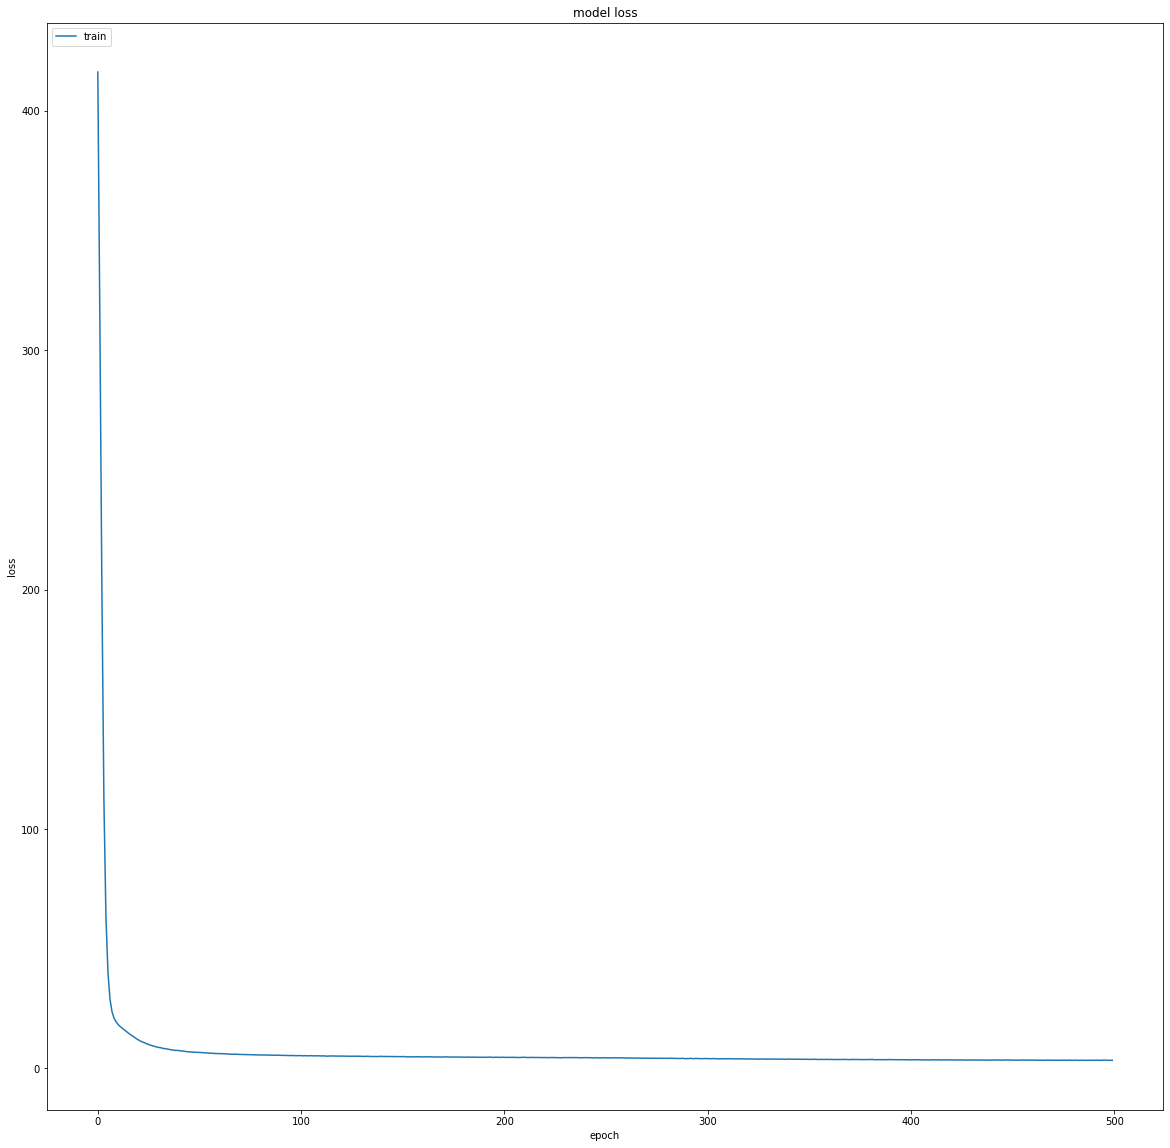

In [98]:
pyplt.plot(history.history['loss'])
pyplt.title('model loss')
pyplt.ylabel('loss')
pyplt.xlabel('epoch')
pyplt.legend(['train', 'test'], loc='upper left')
pyplt.show()

In [99]:
result_epochv1

9.124808189716745

From looking at the above results there definitely seems to deminishing returns or even signs of overfitting after the 300 epoch mark. With that it may be best to introduce early stopping once the loss metric stops reducing.  

###### Test 2 - 500 Epochs with Early Stopping

In [100]:
# Test 2
from keras.callbacks import EarlyStopping
m = ks.models.Sequential()
m.add(ks.layers.Dense(13, input_dim=13, activation="relu"))
m.add(ks.layers.Dense(1))

m.compile(loss="mean_squared_error", optimizer="adam")

#add early stopping
es = EarlyStopping(monitor='loss', patience=10, verbose=1)

history = m.fit(x_train, y_train, epochs=500, batch_size=2, callbacks=[es])

ES_prediction = m.predict(x_test).T

MedianVal_real = y_test.as_matrix().astype(np.float32)

result_ES = m.evaluate(x_test, y_test)

Epoch 1/500
372/372 [==============================] - 1s 4ms/step - loss: 423.8958
Epoch 2/500
372/372 [==============================] - 0s 904us/step - loss: 317.7369
Epoch 3/500
372/372 [==============================] - 0s 888us/step - loss: 194.2544
Epoch 4/500
372/372 [==============================] - 0s 930us/step - loss: 104.3783
Epoch 5/500
372/372 [==============================] - 0s 963us/step - loss: 59.6324
Epoch 6/500
372/372 [==============================] - 0s 821us/step - loss: 40.6217
Epoch 7/500
372/372 [==============================] - 0s 821us/step - loss: 31.6470
Epoch 8/500
372/372 [==============================] - 0s 814us/step - loss: 26.3432
Epoch 9/500
372/372 [==============================] - 0s 936us/step - loss: 22.8615
Epoch 10/500
372/372 [==============================] - 0s 854us/step - loss: 20.2751
Epoch 11/500
372/372 [==============================] - 0s 844us/step - loss: 18.2929
Epoch 12/500
372/372 [==============================] - 0s 81

372/372 [==============================] - 0s 983us/step - loss: 4.9852
Epoch 97/500
372/372 [==============================] - 0s 943us/step - loss: 4.9806
Epoch 98/500
372/372 [==============================] - 0s 892us/step - loss: 4.9956
Epoch 99/500
372/372 [==============================] - 0s 983us/step - loss: 5.0509
Epoch 100/500
372/372 [==============================] - 0s 924us/step - loss: 4.9125
Epoch 101/500
372/372 [==============================] - 0s 1ms/step - loss: 4.9991
Epoch 102/500
372/372 [==============================] - 0s 983us/step - loss: 4.9267
Epoch 103/500
372/372 [==============================] - 0s 984us/step - loss: 4.9110
Epoch 104/500
372/372 [==============================] - 0s 932us/step - loss: 4.9122
Epoch 105/500
372/372 [==============================] - 0s 1ms/step - loss: 4.8924
Epoch 106/500
372/372 [==============================] - 0s 979us/step - loss: 4.8783
Epoch 107/500
372/372 [==============================] - 0s 1ms/step - loss

372/372 [==============================] - 0s 1ms/step - loss: 4.3031
Epoch 192/500
372/372 [==============================] - 0s 927us/step - loss: 4.3349
Epoch 193/500
372/372 [==============================] - 0s 982us/step - loss: 4.2345
Epoch 194/500
372/372 [==============================] - 0s 791us/step - loss: 4.2851
Epoch 195/500
372/372 [==============================] - 0s 866us/step - loss: 4.2378
Epoch 196/500
372/372 [==============================] - 0s 793us/step - loss: 4.3554
Epoch 197/500
372/372 [==============================] - 0s 823us/step - loss: 4.2956
Epoch 198/500
372/372 [==============================] - 0s 1ms/step - loss: 4.2352
Epoch 199/500
372/372 [==============================] - 0s 1ms/step - loss: 4.2658
Epoch 200/500
372/372 [==============================] - 0s 892us/step - loss: 4.2683
Epoch 201/500
372/372 [==============================] - 0s 907us/step - loss: 4.2616
Epoch 202/500
372/372 [==============================] - 0s 988us/step - l

c:\users\conor\anaconda3\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


94/94 [==============================] - 1s 11ms/step


In [101]:
result_ES

9.681382270569497

#### 4.4.2.1 Commentary

Early stopping kicked in at before the 230 epoch mark in most test. This is even when the test was set to only stop when the loss value had no descresed for the previous 10 epochs.

In future there is probably no benefit to be gained from going over 250 Epochs

### 4.4.3 Number of Units per Layer

###### Test 1 - (inputs + outputs) x 2/3

One heuristic is that the number of units in the  hidden layer should be calculated using the above formula. We will test this first.

In [82]:
14*(2/3)


9.333333333333332

In [105]:
# Test 1
m = ks.models.Sequential()
m.add(ks.layers.Dense(9, input_dim=13, activation="relu"))
m.add(ks.layers.Dense(1))

m.compile(loss="mean_squared_error", optimizer="adam")

#add early stopping
es = EarlyStopping(monitor='loss', patience=10, verbose=1)

history = m.fit(x_train, y_train, epochs=250, batch_size=2, callbacks=[es])

layersize9_prediction = m.predict(x_test).T

MedianVal_real = y_test.as_matrix().astype(np.float32)

result_layerN9 = m.evaluate(x_test, y_test)

Epoch 1/250
372/372 [==============================] - 2s 4ms/step - loss: 460.8866
Epoch 2/250
372/372 [==============================] - 0s 1ms/step - loss: 426.1968
Epoch 3/250
372/372 [==============================] - 0s 937us/step - loss: 383.5270
Epoch 4/250
372/372 [==============================] - 0s 890us/step - loss: 310.9910
Epoch 5/250
372/372 [==============================] - 0s 1ms/step - loss: 218.5698
Epoch 6/250
372/372 [==============================] - 0s 926us/step - loss: 135.1001
Epoch 7/250
372/372 [==============================] - 0s 880us/step - loss: 76.7251
Epoch 8/250
372/372 [==============================] - 0s 899us/step - loss: 44.6080
Epoch 9/250
372/372 [==============================] - 0s 877us/step - loss: 31.4327
Epoch 10/250
372/372 [==============================] - 0s 906us/step - loss: 25.7377
Epoch 11/250
372/372 [==============================] - 0s 889us/step - loss: 22.5015
Epoch 12/250
372/372 [==============================] - 0s 906u

372/372 [==============================] - 0s 825us/step - loss: 5.3094
Epoch 98/250
372/372 [==============================] - 0s 824us/step - loss: 5.3275
Epoch 99/250
372/372 [==============================] - 0s 811us/step - loss: 5.2349
Epoch 100/250
372/372 [==============================] - 0s 821us/step - loss: 5.3232
Epoch 101/250
372/372 [==============================] - 0s 844us/step - loss: 5.2128
Epoch 102/250
372/372 [==============================] - 0s 834us/step - loss: 5.2658
Epoch 103/250
372/372 [==============================] - 0s 803us/step - loss: 5.2175
Epoch 104/250
372/372 [==============================] - 0s 790us/step - loss: 5.2301
Epoch 105/250
372/372 [==============================] - 0s 832us/step - loss: 5.2324
Epoch 106/250
372/372 [==============================] - 0s 835us/step - loss: 5.1905
Epoch 107/250
372/372 [==============================] - 0s 827us/step - loss: 5.2150
Epoch 108/250
372/372 [==============================] - 0s 884us/step

372/372 [==============================] - 0s 866us/step - loss: 4.7251
Epoch 193/250
372/372 [==============================] - 0s 806us/step - loss: 4.6578
Epoch 194/250
372/372 [==============================] - 0s 818us/step - loss: 4.7123
Epoch 195/250
372/372 [==============================] - 0s 848us/step - loss: 4.7336
Epoch 196/250
372/372 [==============================] - 0s 830us/step - loss: 4.7129
Epoch 197/250
372/372 [==============================] - 0s 844us/step - loss: 4.6873
Epoch 198/250
372/372 [==============================] - 0s 856us/step - loss: 4.7224
Epoch 199/250
372/372 [==============================] - 0s 1ms/step - loss: 4.6777
Epoch 200/250
372/372 [==============================] - 0s 842us/step - loss: 4.7035
Epoch 201/250
372/372 [==============================] - 0s 1ms/step - loss: 4.6852
Epoch 202/250
372/372 [==============================] - 0s 825us/step - loss: 4.6859
Epoch 203/250
372/372 [==============================] - 0s 1ms/step - l

c:\users\conor\anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


94/94 [==============================] - 1s 12ms/step


In [106]:
result_layerN9

9.390219526087984

###### Test 2 - Twice the number of Inputs

One heuristics is that the number of units in the hidden layer should not be over twice the number of inputs.

In [107]:
# Test 2
m = ks.models.Sequential()
m.add(ks.layers.Dense(26, input_dim=13, activation="relu"))
m.add(ks.layers.Dense(1))

m.compile(loss="mean_squared_error", optimizer="adam")

#add early stopping
es = EarlyStopping(monitor='loss', patience=10, verbose=1)

history = m.fit(x_train, y_train, epochs=250, batch_size=2, callbacks=[es])

layersize26_prediction = m.predict(x_test).T

MedianVal_real = y_test.as_matrix().astype(np.float32)

result_layerN26 = m.evaluate(x_test, y_test)

Epoch 1/250
372/372 [==============================] - 2s 4ms/step - loss: 392.5758
Epoch 2/250
372/372 [==============================] - 0s 1ms/step - loss: 242.2616
Epoch 3/250
372/372 [==============================] - 0s 1ms/step - loss: 108.9472
Epoch 4/250
372/372 [==============================] - 0s 971us/step - loss: 50.8892
Epoch 5/250
372/372 [==============================] - 0s 933us/step - loss: 30.0483
Epoch 6/250
372/372 [==============================] - 0s 963us/step - loss: 21.0509
Epoch 7/250
372/372 [==============================] - 0s 939us/step - loss: 17.2139
Epoch 8/250
372/372 [==============================] - 0s 897us/step - loss: 15.2527
Epoch 9/250
372/372 [==============================] - 0s 873us/step - loss: 14.0787
Epoch 10/250
372/372 [==============================] - 0s 942us/step - loss: 13.29880s - l
Epoch 11/250
372/372 [==============================] - 0s 895us/step - loss: 12.5683
Epoch 12/250
372/372 [==============================] - 0s 8

372/372 [==============================] - 0s 872us/step - loss: 4.1599
Epoch 98/250
372/372 [==============================] - 0s 934us/step - loss: 4.1887
Epoch 99/250
372/372 [==============================] - 0s 999us/step - loss: 4.1618
Epoch 100/250
372/372 [==============================] - 0s 850us/step - loss: 4.1854
Epoch 101/250
372/372 [==============================] - 0s 1ms/step - loss: 4.1227
Epoch 102/250
372/372 [==============================] - 0s 894us/step - loss: 4.1927
Epoch 103/250
372/372 [==============================] - 0s 1ms/step - loss: 4.1163
Epoch 104/250
372/372 [==============================] - 0s 1ms/step - loss: 4.1133
Epoch 105/250
372/372 [==============================] - 0s 933us/step - loss: 4.0796
Epoch 106/250
372/372 [==============================] - 0s 961us/step - loss: 4.0769
Epoch 107/250
372/372 [==============================] - 0s 899us/step - loss: 4.0768
Epoch 108/250
372/372 [==============================] - 0s 917us/step - los

372/372 [==============================] - 0s 847us/step - loss: 3.2977
Epoch 193/250
372/372 [==============================] - 0s 844us/step - loss: 3.3779
Epoch 194/250
372/372 [==============================] - 0s 853us/step - loss: 3.4200
Epoch 195/250
372/372 [==============================] - 0s 984us/step - loss: 3.4106
Epoch 196/250
372/372 [==============================] - 0s 834us/step - loss: 3.3802
Epoch 197/250
372/372 [==============================] - 0s 1ms/step - loss: 3.4543
Epoch 198/250
372/372 [==============================] - 0s 813us/step - loss: 3.3518
Epoch 199/250
372/372 [==============================] - 0s 894us/step - loss: 3.3605
Epoch 200/250
372/372 [==============================] - 0s 1ms/step - loss: 3.3838
Epoch 201/250
372/372 [==============================] - 0s 1ms/step - loss: 3.4022
Epoch 202/250
372/372 [==============================] - 0s 897us/step - loss: 3.3056
Epoch 00202: early stopping


c:\users\conor\anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


94/94 [==============================] - 1s 12ms/step


In [108]:
result_layerN26

8.871564672348347

Using a larger number of units seemed to have a positive effect on performance.

###### Test 3 - Quadrupel the Input

In [109]:
m = ks.models.Sequential()
m.add(ks.layers.Dense(52, input_dim=13, activation="relu"))
m.add(ks.layers.Dense(1))

m.compile(loss="mean_squared_error", optimizer="adam")

#add early stopping
es = EarlyStopping(monitor='loss', patience=10, verbose=1)

history = m.fit(x_train, y_train, epochs=250, batch_size=2, callbacks=[es])

layersize52_prediction = m.predict(x_test).T

MedianVal_real = y_test.as_matrix().astype(np.float32)

result_layerN52 = m.evaluate(x_test, y_test)

Epoch 1/250
372/372 [==============================] - 1s 4ms/step - loss: 368.0212
Epoch 2/250
372/372 [==============================] - ETA: 0s - loss: 156.744 - 0s 911us/step - loss: 151.0924
Epoch 3/250
372/372 [==============================] - 0s 934us/step - loss: 41.5000
Epoch 4/250
372/372 [==============================] - 0s 933us/step - loss: 21.7027
Epoch 5/250
372/372 [==============================] - 0s 1ms/step - loss: 16.2019
Epoch 6/250
372/372 [==============================] - 0s 906us/step - loss: 13.8975
Epoch 7/250
372/372 [==============================] - 0s 917us/step - loss: 12.5814
Epoch 8/250
372/372 [==============================] - 0s 931us/step - loss: 11.5528
Epoch 9/250
372/372 [==============================] - 0s 1ms/step - loss: 10.8873
Epoch 10/250
372/372 [==============================] - 0s 926us/step - loss: 10.0526
Epoch 11/250
372/372 [==============================] - 0s 906us/step - loss: 9.6479
Epoch 12/250
372/372 [====================

372/372 [==============================] - 0s 872us/step - loss: 3.6011
Epoch 98/250
372/372 [==============================] - 0s 825us/step - loss: 3.6185
Epoch 99/250
372/372 [==============================] - 0s 848us/step - loss: 3.5857
Epoch 100/250
372/372 [==============================] - 0s 833us/step - loss: 3.5642
Epoch 101/250
372/372 [==============================] - 0s 978us/step - loss: 3.6040
Epoch 102/250
372/372 [==============================] - 0s 1ms/step - loss: 3.5775
Epoch 103/250
372/372 [==============================] - 0s 985us/step - loss: 3.5769
Epoch 104/250
372/372 [==============================] - 0s 900us/step - loss: 3.4886
Epoch 105/250
372/372 [==============================] - 0s 896us/step - loss: 3.6014
Epoch 106/250
372/372 [==============================] - 0s 845us/step - loss: 3.4141
Epoch 107/250
372/372 [==============================] - 0s 811us/step - loss: 3.5291
Epoch 108/250
372/372 [==============================] - 0s 825us/step -

c:\users\conor\anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


94/94 [==============================] - 1s 12ms/step


In [110]:
result_layerN52

7.379757495636635

Results appear inconclusive again. Need to test mutliple times and get an average.

In [113]:
def unitsize_test(tests, batchsize, unit_size):
    counter = 0
    resultslist = []
    while counter < tests:
        m = ks.models.Sequential()
        m.add(ks.layers.Dense(unit_size, input_dim=13, activation="relu"))
        m.add(ks.layers.Dense(1))

        m.compile(loss="mean_squared_error", optimizer="adam")
        
        es = EarlyStopping(monitor='loss', patience=10, verbose=1)
        
        m.fit(x_train, y_train, epochs=300, batch_size=batchsize, callbacks=[es])

        #unit_prediction = m.predict(x_test).T

        #MedianVal_real = y_test.as_matrix().astype(np.float32)

        result_units = m.evaluate(x_test, y_test)
        counter += 1
        resultslist.append(result_units)
    avg_result = sum(resultslist) / tests
    return avg_result

In [114]:
# hidden layer size = 26
# batch size = 2
# epoch = 300 - with early stopping
print(unitsize_test(5, 2, 26))

Epoch 1/300
372/372 [==============================] - ETA: 0s - loss: 383.744 - 1s 4ms/step - loss: 378.5754
Epoch 2/300
372/372 [==============================] - 0s 898us/step - loss: 223.6563
Epoch 3/300
372/372 [==============================] - 0s 912us/step - loss: 95.7156
Epoch 4/300
372/372 [==============================] - 0s 885us/step - loss: 44.8365
Epoch 5/300
372/372 [==============================] - 0s 921us/step - loss: 28.5246
Epoch 6/300
372/372 [==============================] - 0s 925us/step - loss: 21.2189
Epoch 7/300
372/372 [==============================] - 0s 1ms/step - loss: 17.5249
Epoch 8/300
372/372 [==============================] - 0s 907us/step - loss: 15.5151
Epoch 9/300
372/372 [==============================] - 0s 952us/step - loss: 14.1607
Epoch 10/300
372/372 [==============================] - 0s 910us/step - loss: 13.1872
Epoch 11/300
372/372 [==============================] - 0s 1ms/step - loss: 12.2643
Epoch 12/300
372/372 [===================

372/372 [==============================] - 0s 874us/step - loss: 4.3497
Epoch 98/300
372/372 [==============================] - 0s 899us/step - loss: 4.3277
Epoch 99/300
372/372 [==============================] - 0s 820us/step - loss: 4.3024
Epoch 100/300
372/372 [==============================] - 0s 881us/step - loss: 4.2580
Epoch 101/300
372/372 [==============================] - 0s 834us/step - loss: 4.3012
Epoch 102/300
372/372 [==============================] - 0s 836us/step - loss: 4.2363
Epoch 103/300
372/372 [==============================] - 0s 855us/step - loss: 4.2758
Epoch 104/300
372/372 [==============================] - 0s 838us/step - loss: 4.2763
Epoch 105/300
372/372 [==============================] - 0s 847us/step - loss: 4.2601
Epoch 106/300
372/372 [==============================] - 0s 869us/step - loss: 4.2056
Epoch 107/300
372/372 [==============================] - 0s 823us/step - loss: 4.2819
Epoch 108/300
372/372 [==============================] - 0s 854us/step

372/372 [==============================] - 0s 881us/step - loss: 14.5439
Epoch 10/300
372/372 [==============================] - 0s 857us/step - loss: 13.5508
Epoch 11/300
372/372 [==============================] - 0s 845us/step - loss: 12.7859
Epoch 12/300
372/372 [==============================] - 0s 870us/step - loss: 12.1042
Epoch 13/300
372/372 [==============================] - 0s 828us/step - loss: 11.5224
Epoch 14/300
372/372 [==============================] - 0s 849us/step - loss: 10.9140
Epoch 15/300
372/372 [==============================] - 0s 844us/step - loss: 10.5093
Epoch 16/300
372/372 [==============================] - 0s 863us/step - loss: 9.9781
Epoch 17/300
372/372 [==============================] - 0s 848us/step - loss: 9.6643
Epoch 18/300
372/372 [==============================] - 0s 845us/step - loss: 9.2968
Epoch 19/300
372/372 [==============================] - 0s 849us/step - loss: 9.0035
Epoch 20/300
372/372 [==============================] - 0s 860us/step -

372/372 [==============================] - 0s 868us/step - loss: 4.2699
Epoch 106/300
372/372 [==============================] - 0s 862us/step - loss: 4.2339
Epoch 107/300
372/372 [==============================] - 0s 869us/step - loss: 4.2406
Epoch 108/300
372/372 [==============================] - 0s 856us/step - loss: 4.2448
Epoch 109/300
372/372 [==============================] - 0s 843us/step - loss: 4.1856
Epoch 110/300
372/372 [==============================] - 0s 861us/step - loss: 4.1947
Epoch 111/300
372/372 [==============================] - 0s 851us/step - loss: 4.1807
Epoch 112/300
372/372 [==============================] - 0s 833us/step - loss: 4.1668
Epoch 113/300
372/372 [==============================] - 0s 840us/step - loss: 4.1427
Epoch 114/300
372/372 [==============================] - 0s 852us/step - loss: 4.1725
Epoch 115/300
372/372 [==============================] - 0s 859us/step - loss: 4.1874
Epoch 116/300
372/372 [==============================] - 0s 825us/st

372/372 [==============================] - 0s 1ms/step - loss: 4.9561
Epoch 57/300
372/372 [==============================] - 0s 1ms/step - loss: 4.9872
Epoch 58/300
372/372 [==============================] - 0s 1ms/step - loss: 4.9763
Epoch 59/300
372/372 [==============================] - 0s 1ms/step - loss: 4.8501
Epoch 60/300
372/372 [==============================] - 0s 1ms/step - loss: 4.9373
Epoch 61/300
372/372 [==============================] - 0s 1ms/step - loss: 4.8048
Epoch 62/300
372/372 [==============================] - 0s 1ms/step - loss: 4.7849
Epoch 63/300
372/372 [==============================] - 0s 1ms/step - loss: 4.6707
Epoch 64/300
372/372 [==============================] - 0s 1ms/step - loss: 4.7756
Epoch 65/300
372/372 [==============================] - 0s 1ms/step - loss: 4.7709
Epoch 66/300
372/372 [==============================] - 0s 1ms/step - loss: 4.6873
Epoch 67/300
372/372 [==============================] - 0s 1ms/step - loss: 4.7043
Epoch 68/300
372/

372/372 [==============================] - 0s 1ms/step - loss: 3.5265
Epoch 154/300
372/372 [==============================] - 0s 1ms/step - loss: 3.5555
Epoch 155/300
372/372 [==============================] - 0s 1ms/step - loss: 3.5311
Epoch 156/300
372/372 [==============================] - 0s 907us/step - loss: 3.4959
Epoch 157/300
372/372 [==============================] - 0s 917us/step - loss: 3.5697
Epoch 158/300
372/372 [==============================] - 0s 1ms/step - loss: 3.4857
Epoch 159/300
372/372 [==============================] - 0s 1ms/step - loss: 3.5099
Epoch 160/300
372/372 [==============================] - 0s 904us/step - loss: 3.4974
Epoch 161/300
372/372 [==============================] - 0s 952us/step - loss: 3.5665
Epoch 162/300
372/372 [==============================] - 0s 925us/step - loss: 3.4818
Epoch 163/300
372/372 [==============================] - 0s 954us/step - loss: 3.4536
Epoch 164/300
372/372 [==============================] - 0s 931us/step - loss:

94/94 [==============================] - 1s 14ms/step
Epoch 1/300
372/372 [==============================] - 2s 5ms/step - loss: 379.8781
Epoch 2/300
372/372 [==============================] - 0s 1ms/step - loss: 212.6143
Epoch 3/300
372/372 [==============================] - 0s 1ms/step - loss: 83.4693
Epoch 4/300
372/372 [==============================] - 0s 1ms/step - loss: 37.2856
Epoch 5/300
372/372 [==============================] - 0s 1ms/step - loss: 23.5874
Epoch 6/300
372/372 [==============================] - 0s 1ms/step - loss: 17.8845
Epoch 7/300
372/372 [==============================] - 0s 1ms/step - loss: 15.4261
Epoch 8/300
372/372 [==============================] - 0s 1ms/step - loss: 14.1089
Epoch 9/300
372/372 [==============================] - 0s 1ms/step - loss: 13.1321
Epoch 10/300
372/372 [==============================] - 0s 1ms/step - loss: 12.3113
Epoch 11/300
372/372 [==============================] - 0s 1ms/step - loss: 11.6518
Epoch 12/300
372/372 [=======

372/372 [==============================] - 0s 1ms/step - loss: 4.5910
Epoch 99/300
372/372 [==============================] - 0s 1ms/step - loss: 4.4416
Epoch 100/300
372/372 [==============================] - 0s 1ms/step - loss: 4.5268
Epoch 101/300
372/372 [==============================] - 0s 1ms/step - loss: 4.5574
Epoch 102/300
372/372 [==============================] - 0s 901us/step - loss: 4.4695
Epoch 103/300
372/372 [==============================] - 0s 1ms/step - loss: 4.4508
Epoch 104/300
372/372 [==============================] - 0s 1ms/step - loss: 4.4401
Epoch 105/300
372/372 [==============================] - 0s 1ms/step - loss: 4.4520
Epoch 106/300
372/372 [==============================] - 0s 1ms/step - loss: 4.4179
Epoch 107/300
372/372 [==============================] - 0s 1ms/step - loss: 4.4350
Epoch 108/300
372/372 [==============================] - 0s 1ms/step - loss: 4.4155
Epoch 109/300
372/372 [==============================] - 0s 1ms/step - loss: 4.3860
Epoch

372/372 [==============================] - 0s 1ms/step - loss: 6.0352
Epoch 36/300
372/372 [==============================] - 0s 1ms/step - loss: 6.0575
Epoch 37/300
372/372 [==============================] - 0s 1ms/step - loss: 5.9677
Epoch 38/300
372/372 [==============================] - 0s 1ms/step - loss: 5.9881
Epoch 39/300
372/372 [==============================] - 0s 1ms/step - loss: 5.8290
Epoch 40/300
372/372 [==============================] - 0s 1ms/step - loss: 5.6837
Epoch 41/300
372/372 [==============================] - 0s 1ms/step - loss: 5.7484
Epoch 42/300
372/372 [==============================] - 0s 1ms/step - loss: 5.6496
Epoch 43/300
372/372 [==============================] - 0s 1ms/step - loss: 5.6443
Epoch 44/300
372/372 [==============================] - 0s 1ms/step - loss: 5.5858
Epoch 45/300
372/372 [==============================] - 0s 1ms/step - loss: 5.4309
Epoch 46/300
372/372 [==============================] - 0s 1ms/step - loss: 5.3417
Epoch 47/300
372/

372/372 [==============================] - 0s 1ms/step - loss: 3.8841
Epoch 134/300
372/372 [==============================] - 0s 1ms/step - loss: 3.8114
Epoch 135/300
372/372 [==============================] - 0s 1ms/step - loss: 3.8767
Epoch 136/300
372/372 [==============================] - 0s 1ms/step - loss: 3.8387
Epoch 137/300
372/372 [==============================] - 0s 1ms/step - loss: 3.8472
Epoch 138/300
372/372 [==============================] - 0s 1ms/step - loss: 3.8148
Epoch 139/300
372/372 [==============================] - 0s 958us/step - loss: 3.8123
Epoch 140/300
372/372 [==============================] - 0s 1ms/step - loss: 3.8130
Epoch 141/300
372/372 [==============================] - 0s 963us/step - loss: 3.8669
Epoch 142/300
372/372 [==============================] - 0s 1ms/step - loss: 3.7963
Epoch 143/300
372/372 [==============================] - 0s 1ms/step - loss: 3.8242
Epoch 144/300
372/372 [==============================] - 0s 1ms/step - loss: 3.7557
Ep

Result was 8.461502002147919

In [115]:
# hidden layer size = 26
# batch size = 4
# epoch = 300 - with early stopping
print(unitsize_test(5, 4, 26))

Epoch 1/300
372/372 [==============================] - 2s 4ms/step - loss: 445.1028
Epoch 2/300
372/372 [==============================] - 0s 592us/step - loss: 377.0283
Epoch 3/300
372/372 [==============================] - 0s 620us/step - loss: 285.7136
Epoch 4/300
372/372 [==============================] - 0s 647us/step - loss: 187.2714
Epoch 5/300
372/372 [==============================] - 0s 639us/step - loss: 111.4807
Epoch 6/300
372/372 [==============================] - 0s 631us/step - loss: 68.7038
Epoch 7/300
372/372 [==============================] - 0s 702us/step - loss: 47.2654
Epoch 8/300
372/372 [==============================] - 0s 635us/step - loss: 35.4926
Epoch 9/300
372/372 [==============================] - 0s 635us/step - loss: 28.0448
Epoch 10/300
372/372 [==============================] - 0s 612us/step - loss: 23.0852
Epoch 11/300
372/372 [==============================] - 0s 641us/step - loss: 20.0404
Epoch 12/300
372/372 [==============================] - 0s 6

Epoch 97/300
372/372 [==============================] - 0s 580us/step - loss: 4.4519
Epoch 98/300
372/372 [==============================] - 0s 587us/step - loss: 4.4456
Epoch 99/300
372/372 [==============================] - 0s 561us/step - loss: 4.4054
Epoch 100/300
372/372 [==============================] - 0s 550us/step - loss: 4.3789
Epoch 101/300
372/372 [==============================] - 0s 539us/step - loss: 4.3938
Epoch 102/300
372/372 [==============================] - 0s 554us/step - loss: 4.3796
Epoch 103/300
372/372 [==============================] - 0s 541us/step - loss: 4.3726
Epoch 104/300
372/372 [==============================] - 0s 552us/step - loss: 4.3259
Epoch 105/300
372/372 [==============================] - 0s 542us/step - loss: 4.3587
Epoch 106/300
372/372 [==============================] - 0s 583us/step - loss: 4.3318
Epoch 107/300
372/372 [==============================] - 0s 575us/step - loss: 4.3159
Epoch 108/300
372/372 [==============================] - 

372/372 [==============================] - 0s 571us/step - loss: 3.6335
Epoch 193/300
372/372 [==============================] - 0s 541us/step - loss: 3.5964
Epoch 194/300
372/372 [==============================] - 0s 594us/step - loss: 3.6414
Epoch 195/300
372/372 [==============================] - 0s 645us/step - loss: 3.5808
Epoch 196/300
372/372 [==============================] - 0s 742us/step - loss: 3.5819
Epoch 197/300
372/372 [==============================] - 0s 568us/step - loss: 3.5423
Epoch 198/300
372/372 [==============================] - 0s 551us/step - loss: 3.6072
Epoch 199/300
372/372 [==============================] - 0s 620us/step - loss: 3.5927
Epoch 200/300
372/372 [==============================] - 0s 684us/step - loss: 3.5644
Epoch 201/300
372/372 [==============================] - 0s 608us/step - loss: 3.5677
Epoch 202/300
372/372 [==============================] - 0s 603us/step - loss: 3.5978
Epoch 203/300
372/372 [==============================] - 0s 657us/st

372/372 [==============================] - 0s 594us/step - loss: 3.2752
Epoch 288/300
372/372 [==============================] - 0s 663us/step - loss: 3.2454
Epoch 289/300
372/372 [==============================] - 0s 619us/step - loss: 3.2305
Epoch 290/300
372/372 [==============================] - 0s 575us/step - loss: 3.2269
Epoch 00290: early stopping
94/94 [==============================] - 1s 14ms/step
Epoch 1/300
372/372 [==============================] - 2s 4ms/step - loss: 425.8196
Epoch 2/300
372/372 [==============================] - 0s 583us/step - loss: 348.5034
Epoch 3/300
372/372 [==============================] - 0s 613us/step - loss: 262.4431
Epoch 4/300
372/372 [==============================] - 0s 580us/step - loss: 171.6467
Epoch 5/300
372/372 [==============================] - 0s 584us/step - loss: 99.0598
Epoch 6/300
372/372 [==============================] - 0s 617us/step - loss: 59.1179
Epoch 7/300
372/372 [==============================] - 0s 581us/step - loss:

372/372 [==============================] - 0s 608us/step - loss: 4.9421
Epoch 93/300
372/372 [==============================] - 0s 615us/step - loss: 4.9081
Epoch 94/300
372/372 [==============================] - 0s 546us/step - loss: 4.8647
Epoch 95/300
372/372 [==============================] - 0s 550us/step - loss: 4.8456
Epoch 96/300
372/372 [==============================] - 0s 590us/step - loss: 4.9084
Epoch 97/300
372/372 [==============================] - 0s 643us/step - loss: 4.8064
Epoch 98/300
372/372 [==============================] - 0s 638us/step - loss: 4.8214
Epoch 99/300
372/372 [==============================] - 0s 609us/step - loss: 4.8170
Epoch 100/300
372/372 [==============================] - 0s 634us/step - loss: 4.7827
Epoch 101/300
372/372 [==============================] - 0s 607us/step - loss: 4.7902
Epoch 102/300
372/372 [==============================] - 0s 625us/step - loss: 4.8501
Epoch 103/300
372/372 [==============================] - 0s 557us/step - lo

372/372 [==============================] - 0s 603us/step - loss: 3.9939
Epoch 188/300
372/372 [==============================] - 0s 552us/step - loss: 3.9519
Epoch 189/300
372/372 [==============================] - 0s 560us/step - loss: 3.9268
Epoch 190/300
372/372 [==============================] - 0s 552us/step - loss: 3.9486
Epoch 191/300
372/372 [==============================] - 0s 594us/step - loss: 3.9511
Epoch 192/300
372/372 [==============================] - 0s 571us/step - loss: 3.9322
Epoch 193/300
372/372 [==============================] - 0s 569us/step - loss: 3.9503
Epoch 194/300
372/372 [==============================] - 0s 550us/step - loss: 3.9053
Epoch 195/300
372/372 [==============================] - 0s 560us/step - loss: 3.9125
Epoch 196/300
372/372 [==============================] - 0s 596us/step - loss: 3.9459
Epoch 197/300
372/372 [==============================] - 0s 633us/step - loss: 3.8816
Epoch 198/300
372/372 [==============================] - 0s 654us/st

372/372 [==============================] - 0s 820us/step - loss: 12.3486
Epoch 19/300
372/372 [==============================] - 0s 906us/step - loss: 11.8881
Epoch 20/300
372/372 [==============================] - 0s 775us/step - loss: 11.4744
Epoch 21/300
372/372 [==============================] - 0s 696us/step - loss: 10.9962
Epoch 22/300
372/372 [==============================] - 0s 855us/step - loss: 10.6039
Epoch 23/300
372/372 [==============================] - 0s 851us/step - loss: 10.2516
Epoch 24/300
372/372 [==============================] - 0s 626us/step - loss: 9.8672
Epoch 25/300
372/372 [==============================] - 0s 887us/step - loss: 9.5414
Epoch 26/300
372/372 [==============================] - 0s 602us/step - loss: 9.2232
Epoch 27/300
372/372 [==============================] - 0s 627us/step - loss: 8.9248
Epoch 28/300
372/372 [==============================] - 0s 598us/step - loss: 8.6339
Epoch 29/300
372/372 [==============================] - 0s 797us/step - 

Epoch 114/300
372/372 [==============================] - 0s 611us/step - loss: 4.3964
Epoch 115/300
372/372 [==============================] - 0s 732us/step - loss: 4.4388
Epoch 116/300
372/372 [==============================] - 0s 841us/step - loss: 4.3802
Epoch 117/300
372/372 [==============================] - 0s 559us/step - loss: 4.4582
Epoch 118/300
372/372 [==============================] - 0s 591us/step - loss: 4.3394
Epoch 119/300
372/372 [==============================] - 0s 705us/step - loss: 4.4429
Epoch 120/300
372/372 [==============================] - 0s 583us/step - loss: 4.3554
Epoch 121/300
372/372 [==============================] - 0s 689us/step - loss: 4.3537
Epoch 122/300
372/372 [==============================] - 0s 630us/step - loss: 4.3572
Epoch 123/300
372/372 [==============================] - 0s 660us/step - loss: 4.3812
Epoch 00123: early stopping
94/94 [==============================] - 1s 15ms/step
Epoch 1/300
372/372 [==============================] - 2s 

372/372 [==============================] - 0s 708us/step - loss: 5.0069
Epoch 86/300
372/372 [==============================] - 0s 590us/step - loss: 4.9928
Epoch 87/300
372/372 [==============================] - 0s 635us/step - loss: 4.9889
Epoch 88/300
372/372 [==============================] - 0s 690us/step - loss: 4.9425
Epoch 89/300
372/372 [==============================] - 0s 683us/step - loss: 4.9047
Epoch 90/300
372/372 [==============================] - 0s 651us/step - loss: 4.8721
Epoch 91/300
372/372 [==============================] - 0s 705us/step - loss: 4.8728
Epoch 92/300
372/372 [==============================] - 0s 637us/step - loss: 4.9009
Epoch 93/300
372/372 [==============================] - 0s 597us/step - loss: 4.8456
Epoch 94/300
372/372 [==============================] - 0s 704us/step - loss: 4.8727
Epoch 95/300
372/372 [==============================] - 0s 628us/step - loss: 4.7516
Epoch 96/300
372/372 [==============================] - 0s 649us/step - loss: 

372/372 [==============================] - 0s 598us/step - loss: 3.7071
Epoch 181/300
372/372 [==============================] - 0s 561us/step - loss: 3.7951
Epoch 182/300
372/372 [==============================] - 0s 574us/step - loss: 3.7088
Epoch 183/300
372/372 [==============================] - 0s 548us/step - loss: 3.6856
Epoch 184/300
372/372 [==============================] - 0s 655us/step - loss: 3.7336
Epoch 185/300
372/372 [==============================] - 0s 611us/step - loss: 3.7594
Epoch 186/300
372/372 [==============================] - 0s 587us/step - loss: 3.7592
Epoch 187/300
372/372 [==============================] - 0s 561us/step - loss: 3.6617
Epoch 188/300
372/372 [==============================] - 0s 553us/step - loss: 3.6655
Epoch 189/300
372/372 [==============================] - 0s 594us/step - loss: 3.6551
Epoch 190/300
372/372 [==============================] - 0s 589us/step - loss: 3.7574
Epoch 191/300
372/372 [==============================] - 0s 549us/st

Epoch 59/300
372/372 [==============================] - 0s 562us/step - loss: 5.7727
Epoch 60/300
372/372 [==============================] - 0s 574us/step - loss: 5.7204
Epoch 61/300
372/372 [==============================] - 0s 581us/step - loss: 5.6998
Epoch 62/300
372/372 [==============================] - 0s 604us/step - loss: 5.7069
Epoch 63/300
372/372 [==============================] - 0s 636us/step - loss: 5.7039
Epoch 64/300
372/372 [==============================] - 0s 590us/step - loss: 5.6469
Epoch 65/300
372/372 [==============================] - 0s 584us/step - loss: 5.5825
Epoch 66/300
372/372 [==============================] - 0s 556us/step - loss: 5.5345
Epoch 67/300
372/372 [==============================] - 0s 563us/step - loss: 5.4823
Epoch 68/300
372/372 [==============================] - 0s 575us/step - loss: 5.5068
Epoch 69/300
372/372 [==============================] - 0s 587us/step - loss: 5.3971
Epoch 70/300
372/372 [==============================] - 0s 604us/

372/372 [==============================] - 0s 553us/step - loss: 4.2292
Epoch 155/300
372/372 [==============================] - 0s 587us/step - loss: 4.2119
Epoch 156/300
372/372 [==============================] - 0s 577us/step - loss: 4.1469
Epoch 157/300
372/372 [==============================] - 0s 687us/step - loss: 4.2293
Epoch 158/300
372/372 [==============================] - 0s 620us/step - loss: 4.1359
Epoch 159/300
372/372 [==============================] - 0s 584us/step - loss: 4.1819
Epoch 160/300
372/372 [==============================] - 0s 555us/step - loss: 4.1631
Epoch 161/300
372/372 [==============================] - 0s 571us/step - loss: 4.1855
Epoch 162/300
372/372 [==============================] - 0s 587us/step - loss: 4.1280
Epoch 163/300
372/372 [==============================] - 0s 610us/step - loss: 4.0285
Epoch 164/300
372/372 [==============================] - 0s 610us/step - loss: 4.1503
Epoch 165/300
372/372 [==============================] - 0s 612us/st

Result was 7.670181302821382

In [116]:
# hidden layer size = 52
# batch size = 2
# epoch = 300 - with early stopping
print(unitsize_test(5, 2, 52))

Epoch 1/300
372/372 [==============================] - 2s 6ms/step - loss: 363.0518
Epoch 2/300
372/372 [==============================] - 0s 1ms/step - loss: 163.6677
Epoch 3/300
372/372 [==============================] - 1s 1ms/step - loss: 48.4726
Epoch 4/300
372/372 [==============================] - 0s 1ms/step - loss: 23.9482
Epoch 5/300
372/372 [==============================] - 0s 1ms/step - loss: 16.5746
Epoch 6/300
372/372 [==============================] - 0s 1ms/step - loss: 13.8100
Epoch 7/300
372/372 [==============================] - 0s 1ms/step - loss: 12.4814
Epoch 8/300
372/372 [==============================] - 1s 1ms/step - loss: 11.3963
Epoch 9/300
372/372 [==============================] - 0s 1ms/step - loss: 10.5607
Epoch 10/300
372/372 [==============================] - 0s 1ms/step - loss: 9.8773
Epoch 11/300
372/372 [==============================] - 0s 1ms/step - loss: 9.2396
Epoch 12/300
372/372 [==============================] - 0s 1ms/step - loss: 8.6066
Ep

372/372 [==============================] - 0s 1ms/step - loss: 3.3933
Epoch 100/300
372/372 [==============================] - 0s 1ms/step - loss: 3.5176
Epoch 101/300
372/372 [==============================] - 0s 1ms/step - loss: 3.4717
Epoch 102/300
372/372 [==============================] - 0s 1ms/step - loss: 3.5278
Epoch 103/300
372/372 [==============================] - 0s 1ms/step - loss: 3.5086
Epoch 104/300
372/372 [==============================] - 0s 1ms/step - loss: 3.5044
Epoch 105/300
372/372 [==============================] - 0s 1ms/step - loss: 3.4791
Epoch 106/300
372/372 [==============================] - 0s 1ms/step - loss: 3.4780
Epoch 107/300
372/372 [==============================] - 0s 1ms/step - loss: 3.4344
Epoch 108/300
372/372 [==============================] - 0s 1ms/step - loss: 3.4338
Epoch 109/300
372/372 [==============================] - 0s 1ms/step - loss: 3.4691
Epoch 00109: early stopping
94/94 [==============================] - 1s 15ms/step
Epoch 1/

372/372 [==============================] - 0s 1ms/step - loss: 3.8278
Epoch 88/300
372/372 [==============================] - 0s 1ms/step - loss: 3.8335
Epoch 89/300
372/372 [==============================] - 0s 1ms/step - loss: 3.7277
Epoch 90/300
372/372 [==============================] - 0s 1ms/step - loss: 3.6877
Epoch 91/300
372/372 [==============================] - 0s 1ms/step - loss: 3.7632
Epoch 92/300
372/372 [==============================] - 0s 1ms/step - loss: 3.7324
Epoch 93/300
372/372 [==============================] - 0s 1ms/step - loss: 3.6979
Epoch 94/300
372/372 [==============================] - 0s 1ms/step - loss: 3.6439
Epoch 95/300
372/372 [==============================] - 0s 1ms/step - loss: 3.5972
Epoch 96/300
372/372 [==============================] - 0s 1ms/step - loss: 3.6103
Epoch 97/300
372/372 [==============================] - 0s 1ms/step - loss: 3.6143
Epoch 98/300
372/372 [==============================] - 0s 1ms/step - loss: 3.6471
Epoch 99/300
372/

372/372 [==============================] - 0s 1ms/step - loss: 4.7475
Epoch 48/300
372/372 [==============================] - 0s 1ms/step - loss: 4.6562
Epoch 49/300
372/372 [==============================] - 0s 1ms/step - loss: 4.6487
Epoch 50/300
372/372 [==============================] - 0s 1ms/step - loss: 4.5446
Epoch 51/300
372/372 [==============================] - 0s 1ms/step - loss: 4.5492
Epoch 52/300
372/372 [==============================] - 0s 1ms/step - loss: 4.6352
Epoch 53/300
372/372 [==============================] - 0s 1ms/step - loss: 4.4974
Epoch 54/300
372/372 [==============================] - 1s 1ms/step - loss: 4.4810
Epoch 55/300
372/372 [==============================] - 0s 1ms/step - loss: 4.4752
Epoch 56/300
372/372 [==============================] - 1s 1ms/step - loss: 4.3796
Epoch 57/300
372/372 [==============================] - 1s 1ms/step - loss: 4.3911
Epoch 58/300
372/372 [==============================] - 1s 1ms/step - loss: 4.4021
Epoch 59/300
372/

372/372 [==============================] - 0s 1ms/step - loss: 3.3456
Epoch 145/300
372/372 [==============================] - 0s 1ms/step - loss: 3.3373
Epoch 146/300
372/372 [==============================] - 0s 1ms/step - loss: 3.3627
Epoch 147/300
372/372 [==============================] - 0s 1ms/step - loss: 3.3766
Epoch 148/300
372/372 [==============================] - 0s 1ms/step - loss: 3.3480
Epoch 149/300
372/372 [==============================] - 0s 1ms/step - loss: 3.4156
Epoch 150/300
372/372 [==============================] - 0s 1ms/step - loss: 3.3285
Epoch 151/300
372/372 [==============================] - 0s 1ms/step - loss: 3.3923
Epoch 152/300
372/372 [==============================] - 0s 1ms/step - loss: 3.3507
Epoch 153/300
372/372 [==============================] - 0s 1ms/step - loss: 3.3372
Epoch 154/300
372/372 [==============================] - 0s 1ms/step - loss: 3.3313
Epoch 155/300
372/372 [==============================] - 0s 1ms/step - loss: 3.3154
Epoch 

372/372 [==============================] - 0s 1ms/step - loss: 42.6910
Epoch 4/300
372/372 [==============================] - 1s 1ms/step - loss: 25.1326
Epoch 5/300
372/372 [==============================] - 0s 1ms/step - loss: 19.1266
Epoch 6/300
372/372 [==============================] - 0s 1ms/step - loss: 16.7543
Epoch 7/300
372/372 [==============================] - 0s 1ms/step - loss: 15.1713
Epoch 8/300
372/372 [==============================] - 1s 1ms/step - loss: 13.9693
Epoch 9/300
372/372 [==============================] - 0s 1ms/step - loss: 12.9228
Epoch 10/300
372/372 [==============================] - 0s 1ms/step - loss: 11.9991
Epoch 11/300
372/372 [==============================] - 0s 1ms/step - loss: 11.2233
Epoch 12/300
372/372 [==============================] - 0s 1ms/step - loss: 10.5506
Epoch 13/300
372/372 [==============================] - 1s 2ms/step - loss: 9.8808
Epoch 14/300
372/372 [==============================] - 1s 1ms/step - loss: 9.2858
Epoch 15/300


372/372 [==============================] - 0s 1ms/step - loss: 3.8304
Epoch 102/300
372/372 [==============================] - 0s 1ms/step - loss: 3.7261
Epoch 103/300
372/372 [==============================] - ETA: 0s - loss: 3.860 - 0s 1ms/step - loss: 3.8830
Epoch 104/300
372/372 [==============================] - 0s 1ms/step - loss: 3.7134
Epoch 105/300
372/372 [==============================] - 0s 1ms/step - loss: 3.8218
Epoch 106/300
372/372 [==============================] - 0s 1ms/step - loss: 3.7252
Epoch 107/300
372/372 [==============================] - 0s 1ms/step - loss: 3.7271
Epoch 108/300
372/372 [==============================] - 0s 1ms/step - loss: 3.6977
Epoch 109/300
372/372 [==============================] - 0s 1ms/step - loss: 3.6531
Epoch 110/300
372/372 [==============================] - 0s 1ms/step - loss: 3.7354
Epoch 111/300
372/372 [==============================] - 0s 1ms/step - loss: 3.6874
Epoch 112/300
372/372 [==============================] - 1s 1ms/st

372/372 [==============================] - 1s 1ms/step - loss: 6.3099
Epoch 24/300
372/372 [==============================] - 0s 1ms/step - loss: 6.1313
Epoch 25/300
372/372 [==============================] - 1s 2ms/step - loss: 6.0052
Epoch 26/300
372/372 [==============================] - 0s 1ms/step - loss: 6.0492
Epoch 27/300
372/372 [==============================] - 0s 1ms/step - loss: 5.8357
Epoch 28/300
372/372 [==============================] - 1s 1ms/step - loss: 5.7538
Epoch 29/300
372/372 [==============================] - 0s 1ms/step - loss: 5.6945
Epoch 30/300
372/372 [==============================] - 0s 1ms/step - loss: 5.6199
Epoch 31/300
372/372 [==============================] - 0s 1ms/step - loss: 5.5304
Epoch 32/300
372/372 [==============================] - 0s 1ms/step - loss: 5.5192
Epoch 33/300
372/372 [==============================] - 0s 1ms/step - loss: 5.4661
Epoch 34/300
372/372 [==============================] - 1s 1ms/step - loss: 5.3556
Epoch 35/300
372/

372/372 [==============================] - 0s 1ms/step - loss: 3.3247
Epoch 122/300
372/372 [==============================] - 0s 1ms/step - loss: 3.1676
Epoch 123/300
372/372 [==============================] - 0s 1ms/step - loss: 3.2213
Epoch 124/300
372/372 [==============================] - 0s 1ms/step - loss: 3.2210
Epoch 125/300
372/372 [==============================] - 0s 1ms/step - loss: 3.2262
Epoch 126/300
372/372 [==============================] - 0s 1ms/step - loss: 3.1386
Epoch 127/300
372/372 [==============================] - 0s 1ms/step - loss: 3.1189
Epoch 128/300
372/372 [==============================] - 0s 1ms/step - loss: 3.2534
Epoch 129/300
372/372 [==============================] - 0s 1ms/step - loss: 3.1910
Epoch 130/300
372/372 [==============================] - 0s 1ms/step - loss: 3.0953
Epoch 131/300
372/372 [==============================] - 0s 1ms/step - loss: 3.0553
Epoch 132/300
372/372 [==============================] - 0s 1ms/step - loss: 3.1185
Epoch 

372/372 [==============================] - 1s 1ms/step - loss: 2.4128
Epoch 219/300
372/372 [==============================] - 0s 1ms/step - loss: 2.5127
Epoch 220/300
372/372 [==============================] - 1s 1ms/step - loss: 2.3832
Epoch 221/300
372/372 [==============================] - 1s 1ms/step - loss: 2.3587
Epoch 222/300
372/372 [==============================] - 0s 1ms/step - loss: 2.4091
Epoch 223/300
372/372 [==============================] - 0s 1ms/step - loss: 2.3541
Epoch 224/300
372/372 [==============================] - 0s 1ms/step - loss: 2.3305
Epoch 225/300
372/372 [==============================] - 0s 1ms/step - loss: 2.3475
Epoch 226/300
372/372 [==============================] - 1s 1ms/step - loss: 2.3382
Epoch 227/300
372/372 [==============================] - 1s 1ms/step - loss: 2.3059
Epoch 228/300
372/372 [==============================] - 0s 1ms/step - loss: 2.2809
Epoch 229/300
372/372 [==============================] - 0s 1ms/step - loss: 2.3968
Epoch 

Result was 8.024365358149751

In [117]:
# hidden layer size = 52
# batch size = 4
# epoch = 300 - with early stopping
print(unitsize_test(5, 4, 52))

Epoch 1/300
372/372 [==============================] - 2s 4ms/step - loss: 396.2296
Epoch 2/300
372/372 [==============================] - 0s 506us/step - loss: 274.1521
Epoch 3/300
372/372 [==============================] - 0s 535us/step - loss: 143.0321
Epoch 4/300
372/372 [==============================] - 0s 533us/step - loss: 65.2844
Epoch 5/300
372/372 [==============================] - 0s 535us/step - loss: 36.1948
Epoch 6/300
372/372 [==============================] - 0s 616us/step - loss: 24.1897
Epoch 7/300
372/372 [==============================] - 0s 581us/step - loss: 18.5892
Epoch 8/300
372/372 [==============================] - 0s 527us/step - loss: 16.0558
Epoch 9/300
372/372 [==============================] - 0s 532us/step - loss: 14.6671
Epoch 10/300
372/372 [==============================] - 0s 519us/step - loss: 13.7796
Epoch 11/300
372/372 [==============================] - 0s 717us/step - loss: 13.0248
Epoch 12/300
372/372 [==============================] - 0s 865

372/372 [==============================] - 0s 521us/step - loss: 4.0491
Epoch 98/300
372/372 [==============================] - 0s 489us/step - loss: 4.0254
Epoch 99/300
372/372 [==============================] - 0s 495us/step - loss: 3.9154
Epoch 100/300
372/372 [==============================] - 0s 506us/step - loss: 4.0453
Epoch 101/300
372/372 [==============================] - 0s 494us/step - loss: 3.9037
Epoch 102/300
372/372 [==============================] - 0s 510us/step - loss: 3.9132
Epoch 103/300
372/372 [==============================] - 0s 483us/step - loss: 3.9164
Epoch 104/300
372/372 [==============================] - 0s 483us/step - loss: 3.8381
Epoch 105/300
372/372 [==============================] - 0s 582us/step - loss: 3.8243
Epoch 106/300
372/372 [==============================] - 0s 586us/step - loss: 3.9404
Epoch 107/300
372/372 [==============================] - 0s 514us/step - loss: 3.9377
Epoch 108/300
372/372 [==============================] - 0s 476us/step

Epoch 41/300
372/372 [==============================] - 0s 497us/step - loss: 5.7973
Epoch 42/300
372/372 [==============================] - 0s 499us/step - loss: 5.7638
Epoch 43/300
372/372 [==============================] - 0s 503us/step - loss: 5.6782
Epoch 44/300
372/372 [==============================] - 0s 484us/step - loss: 5.6440
Epoch 45/300
372/372 [==============================] - 0s 498us/step - loss: 5.5886 0s - loss: 4.5
Epoch 46/300
372/372 [==============================] - 0s 485us/step - loss: 5.4940
Epoch 47/300
372/372 [==============================] - 0s 495us/step - loss: 5.4960
Epoch 48/300
372/372 [==============================] - 0s 506us/step - loss: 5.4208
Epoch 49/300
372/372 [==============================] - 0s 508us/step - loss: 5.4117
Epoch 50/300
372/372 [==============================] - 0s 494us/step - loss: 5.3658
Epoch 51/300
372/372 [==============================] - 0s 479us/step - loss: 5.2542
Epoch 52/300
372/372 [============================

372/372 [==============================] - 0s 508us/step - loss: 3.3626
Epoch 137/300
372/372 [==============================] - 0s 493us/step - loss: 3.3415
Epoch 138/300
372/372 [==============================] - 0s 485us/step - loss: 3.3027
Epoch 139/300
372/372 [==============================] - 0s 520us/step - loss: 3.3181
Epoch 140/300
372/372 [==============================] - 0s 484us/step - loss: 3.2832
Epoch 141/300
372/372 [==============================] - 0s 501us/step - loss: 3.2752
Epoch 142/300
372/372 [==============================] - 0s 510us/step - loss: 3.2633
Epoch 143/300
372/372 [==============================] - 0s 500us/step - loss: 3.2506
Epoch 144/300
372/372 [==============================] - 0s 507us/step - loss: 3.3346
Epoch 145/300
372/372 [==============================] - 0s 502us/step - loss: 3.2414
Epoch 146/300
372/372 [==============================] - 0s 486us/step - loss: 3.1935
Epoch 147/300
372/372 [==============================] - 0s 518us/st

372/372 [==============================] - 0s 511us/step - loss: 9.0271
Epoch 20/300
372/372 [==============================] - 0s 497us/step - loss: 8.8784
Epoch 21/300
372/372 [==============================] - 0s 495us/step - loss: 8.4240
Epoch 22/300
372/372 [==============================] - 0s 513us/step - loss: 8.2270
Epoch 23/300
372/372 [==============================] - 0s 512us/step - loss: 7.9717
Epoch 24/300
372/372 [==============================] - 0s 523us/step - loss: 7.7406
Epoch 25/300
372/372 [==============================] - 0s 482us/step - loss: 7.5730
Epoch 26/300
372/372 [==============================] - 0s 486us/step - loss: 7.3843
Epoch 27/300
372/372 [==============================] - 0s 507us/step - loss: 7.2261
Epoch 28/300
372/372 [==============================] - 0s 495us/step - loss: 7.0764
Epoch 29/300
372/372 [==============================] - 0s 504us/step - loss: 6.8677
Epoch 30/300
372/372 [==============================] - 0s 497us/step - loss: 

372/372 [==============================] - 0s 528us/step - loss: 3.9741 0s - loss: 3.971
Epoch 115/300
372/372 [==============================] - 0s 512us/step - loss: 3.9479
Epoch 116/300
372/372 [==============================] - 0s 490us/step - loss: 3.9323
Epoch 117/300
372/372 [==============================] - 0s 491us/step - loss: 3.8783
Epoch 118/300
372/372 [==============================] - 0s 504us/step - loss: 3.9376
Epoch 119/300
372/372 [==============================] - 0s 510us/step - loss: 3.7834
Epoch 120/300
372/372 [==============================] - 0s 496us/step - loss: 3.9385
Epoch 121/300
372/372 [==============================] - 0s 517us/step - loss: 3.8240
Epoch 122/300
372/372 [==============================] - 0s 501us/step - loss: 3.8594
Epoch 123/300
372/372 [==============================] - 0s 502us/step - loss: 3.8042
Epoch 124/300
372/372 [==============================] - 0s 503us/step - loss: 3.7727
Epoch 125/300
372/372 [============================

372/372 [==============================] - 0s 542us/step - loss: 3.1174 0s - loss: 2.79
Epoch 209/300
372/372 [==============================] - 0s 506us/step - loss: 3.2140
Epoch 210/300
372/372 [==============================] - 0s 514us/step - loss: 3.1665 0s - loss: 3.087
Epoch 211/300
372/372 [==============================] - 0s 498us/step - loss: 3.1200
Epoch 212/300
372/372 [==============================] - 0s 495us/step - loss: 3.0445
Epoch 213/300
372/372 [==============================] - 0s 517us/step - loss: 3.0730
Epoch 214/300
372/372 [==============================] - 0s 515us/step - loss: 3.1452
Epoch 215/300
372/372 [==============================] - 0s 501us/step - loss: 3.1654
Epoch 216/300
372/372 [==============================] - 0s 507us/step - loss: 3.0475
Epoch 217/300
372/372 [==============================] - 0s 496us/step - loss: 3.0840
Epoch 218/300
372/372 [==============================] - 0s 486us/step - loss: 3.0996
Epoch 219/300
372/372 [============

372/372 [==============================] - 0s 520us/step - loss: 5.4529
Epoch 49/300
372/372 [==============================] - 0s 516us/step - loss: 5.4192
Epoch 50/300
372/372 [==============================] - 0s 685us/step - loss: 5.3427
Epoch 51/300
372/372 [==============================] - 0s 586us/step - loss: 5.3114
Epoch 52/300
372/372 [==============================] - 0s 616us/step - loss: 5.3155
Epoch 53/300
372/372 [==============================] - 0s 663us/step - loss: 5.2382
Epoch 54/300
372/372 [==============================] - 0s 524us/step - loss: 5.2704
Epoch 55/300
372/372 [==============================] - 0s 490us/step - loss: 5.2127
Epoch 56/300
372/372 [==============================] - 0s 576us/step - loss: 5.1424
Epoch 57/300
372/372 [==============================] - 0s 732us/step - loss: 5.1735
Epoch 58/300
372/372 [==============================] - 0s 505us/step - loss: 5.0589
Epoch 59/300
372/372 [==============================] - 0s 529us/step - loss: 

372/372 [==============================] - 0s 518us/step - loss: 3.7299
Epoch 144/300
372/372 [==============================] - 0s 497us/step - loss: 3.7154
Epoch 145/300
372/372 [==============================] - 0s 503us/step - loss: 3.7357
Epoch 146/300
372/372 [==============================] - 0s 495us/step - loss: 3.6822
Epoch 147/300
372/372 [==============================] - 0s 494us/step - loss: 3.6432
Epoch 148/300
372/372 [==============================] - 0s 496us/step - loss: 3.6985
Epoch 149/300
372/372 [==============================] - 0s 507us/step - loss: 3.7745
Epoch 150/300
372/372 [==============================] - 0s 499us/step - loss: 3.6620
Epoch 151/300
372/372 [==============================] - 0s 527us/step - loss: 3.6239
Epoch 152/300
372/372 [==============================] - 0s 495us/step - loss: 3.7590
Epoch 153/300
372/372 [==============================] - 0s 496us/step - loss: 3.6246
Epoch 154/300
372/372 [==============================] - 0s 498us/st

372/372 [==============================] - 0s 410us/step - loss: 13.0808
Epoch 15/300
372/372 [==============================] - 0s 491us/step - loss: 12.3838
Epoch 16/300
372/372 [==============================] - 0s 599us/step - loss: 11.7417
Epoch 17/300
372/372 [==============================] - 0s 530us/step - loss: 11.1588
Epoch 18/300
372/372 [==============================] - 0s 512us/step - loss: 10.6059
Epoch 19/300
372/372 [==============================] - 0s 508us/step - loss: 10.1175
Epoch 20/300
372/372 [==============================] - 0s 517us/step - loss: 9.7037
Epoch 21/300
372/372 [==============================] - 0s 504us/step - loss: 9.3137
Epoch 22/300
372/372 [==============================] - 0s 519us/step - loss: 8.9188
Epoch 23/300
372/372 [==============================] - 0s 510us/step - loss: 8.5765
Epoch 24/300
372/372 [==============================] - 0s 515us/step - loss: 8.2050
Epoch 25/300
372/372 [==============================] - 0s 525us/step - 

372/372 [==============================] - 0s 652us/step - loss: 3.9142
Epoch 110/300
372/372 [==============================] - 0s 610us/step - loss: 3.8623
Epoch 111/300
372/372 [==============================] - 0s 570us/step - loss: 3.8287
Epoch 112/300
372/372 [==============================] - 0s 549us/step - loss: 3.8397
Epoch 113/300
372/372 [==============================] - 0s 634us/step - loss: 3.7980
Epoch 114/300
372/372 [==============================] - 0s 721us/step - loss: 3.8596
Epoch 115/300
372/372 [==============================] - 0s 525us/step - loss: 3.8175
Epoch 116/300
372/372 [==============================] - 0s 513us/step - loss: 3.8111
Epoch 117/300
372/372 [==============================] - 0s 525us/step - loss: 3.7589
Epoch 118/300
372/372 [==============================] - 0s 519us/step - loss: 3.7783
Epoch 119/300
372/372 [==============================] - 0s 503us/step - loss: 3.7038
Epoch 120/300
372/372 [==============================] - 0s 619us/st

372/372 [==============================] - 0s 534us/step - loss: 3.0310
Epoch 205/300
372/372 [==============================] - 0s 530us/step - loss: 3.0688
Epoch 206/300
372/372 [==============================] - 0s 515us/step - loss: 2.9927
Epoch 207/300
372/372 [==============================] - 0s 516us/step - loss: 3.0416
Epoch 208/300
372/372 [==============================] - 0s 503us/step - loss: 3.1539
Epoch 209/300
372/372 [==============================] - 0s 492us/step - loss: 2.9786
Epoch 210/300
372/372 [==============================] - 0s 504us/step - loss: 3.0446
Epoch 211/300
372/372 [==============================] - 0s 507us/step - loss: 3.0241
Epoch 212/300
372/372 [==============================] - 0s 519us/step - loss: 3.0051
Epoch 213/300
372/372 [==============================] - 0s 495us/step - loss: 3.0381
Epoch 214/300
372/372 [==============================] - 0s 511us/step - loss: 3.0374
Epoch 215/300
372/372 [==============================] - 0s 536us/st

Result was 7.862417864292226

In [118]:
# hidden layer size = 64
# batch size = 2
# epoch = 300 - with early stopping
print(unitsize_test(5, 2, 64))

Epoch 1/300
372/372 [==============================] - 2s 5ms/step - loss: 377.6059
Epoch 2/300
372/372 [==============================] - 0s 1ms/step - loss: 149.7586
Epoch 3/300
372/372 [==============================] - 0s 1ms/step - loss: 37.7218
Epoch 4/300
372/372 [==============================] - 0s 1ms/step - loss: 20.7409
Epoch 5/300
372/372 [==============================] - 0s 1ms/step - loss: 16.6801
Epoch 6/300
372/372 [==============================] - 0s 1ms/step - loss: 14.8866
Epoch 7/300
372/372 [==============================] - 0s 1ms/step - loss: 13.5927
Epoch 8/300
372/372 [==============================] - 0s 1ms/step - loss: 12.6257
Epoch 9/300
372/372 [==============================] - 0s 1ms/step - loss: 11.6537
Epoch 10/300
372/372 [==============================] - 0s 1ms/step - loss: 10.7816
Epoch 11/300
372/372 [==============================] - 0s 1ms/step - loss: 10.1827
Epoch 12/300
372/372 [==============================] - 0s 1ms/step - loss: 9.4343


372/372 [==============================] - 0s 992us/step - loss: 3.4220
Epoch 99/300
372/372 [==============================] - 0s 974us/step - loss: 3.5014
Epoch 100/300
372/372 [==============================] - 0s 1ms/step - loss: 3.4722
Epoch 101/300
372/372 [==============================] - 0s 1ms/step - loss: 3.4728
Epoch 102/300
372/372 [==============================] - 0s 982us/step - loss: 3.5497
Epoch 103/300
372/372 [==============================] - 0s 996us/step - loss: 3.4427
Epoch 104/300
372/372 [==============================] - 0s 992us/step - loss: 3.4535
Epoch 105/300
372/372 [==============================] - 0s 978us/step - loss: 3.4926
Epoch 106/300
372/372 [==============================] - 0s 980us/step - loss: 3.4399
Epoch 107/300
372/372 [==============================] - 0s 965us/step - loss: 3.4041
Epoch 108/300
372/372 [==============================] - 0s 979us/step - loss: 3.3475
Epoch 109/300
372/372 [==============================] - 0s 975us/step - 

372/372 [==============================] - 0s 993us/step - loss: 6.2164
Epoch 23/300
372/372 [==============================] - 0s 951us/step - loss: 6.0200
Epoch 24/300
372/372 [==============================] - 0s 981us/step - loss: 5.9032
Epoch 25/300
372/372 [==============================] - 0s 954us/step - loss: 5.8280
Epoch 26/300
372/372 [==============================] - 0s 968us/step - loss: 5.7940
Epoch 27/300
372/372 [==============================] - 0s 974us/step - loss: 5.6890 0s - loss: 
Epoch 28/300
372/372 [==============================] - 0s 980us/step - loss: 5.6800
Epoch 29/300
372/372 [==============================] - 0s 951us/step - loss: 5.5611
Epoch 30/300
372/372 [==============================] - 0s 983us/step - loss: 5.5313
Epoch 31/300
372/372 [==============================] - 0s 951us/step - loss: 5.4596
Epoch 32/300
372/372 [==============================] - 0s 998us/step - loss: 5.4185
Epoch 33/300
372/372 [==============================] - 0s 942us/s

372/372 [==============================] - 0s 1ms/step - loss: 3.1135
Epoch 120/300
372/372 [==============================] - 0s 985us/step - loss: 3.1307
Epoch 121/300
372/372 [==============================] - 0s 1ms/step - loss: 3.1559
Epoch 122/300
372/372 [==============================] - 0s 940us/step - loss: 3.1739
Epoch 123/300
372/372 [==============================] - 0s 951us/step - loss: 3.1631
Epoch 124/300
372/372 [==============================] - 0s 1ms/step - loss: 3.0124
Epoch 125/300
372/372 [==============================] - 0s 975us/step - loss: 3.1358
Epoch 126/300
372/372 [==============================] - 0s 940us/step - loss: 3.0712
Epoch 127/300
372/372 [==============================] - 0s 1ms/step - loss: 3.0582
Epoch 128/300
372/372 [==============================] - 0s 956us/step - loss: 3.0714
Epoch 129/300
372/372 [==============================] - 0s 1ms/step - loss: 3.1090
Epoch 130/300
372/372 [==============================] - 0s 975us/step - loss:

372/372 [==============================] - 0s 1ms/step - loss: 4.1812
Epoch 55/300
372/372 [==============================] - 0s 985us/step - loss: 4.2786
Epoch 56/300
372/372 [==============================] - 0s 970us/step - loss: 4.3038
Epoch 57/300
372/372 [==============================] - 0s 1ms/step - loss: 4.1272
Epoch 58/300
372/372 [==============================] - 0s 1ms/step - loss: 4.0987
Epoch 59/300
372/372 [==============================] - 0s 1ms/step - loss: 4.1436
Epoch 60/300
372/372 [==============================] - 0s 984us/step - loss: 4.0826
Epoch 61/300
372/372 [==============================] - 0s 993us/step - loss: 4.0065
Epoch 62/300
372/372 [==============================] - 0s 1ms/step - loss: 4.0771
Epoch 63/300
372/372 [==============================] - 0s 1ms/step - loss: 4.0264
Epoch 64/300
372/372 [==============================] - 0s 1ms/step - loss: 3.9909
Epoch 65/300
372/372 [==============================] - 0s 999us/step - loss: 3.9161
Epoch 6

372/372 [==============================] - 0s 1ms/step - loss: 4.6913
Epoch 43/300
372/372 [==============================] - 0s 988us/step - loss: 4.7412
Epoch 44/300
372/372 [==============================] - 0s 1ms/step - loss: 4.6776
Epoch 45/300
372/372 [==============================] - 0s 1ms/step - loss: 4.6184
Epoch 46/300
372/372 [==============================] - 0s 971us/step - loss: 4.5489
Epoch 47/300
372/372 [==============================] - 0s 993us/step - loss: 4.6492
Epoch 48/300
372/372 [==============================] - 0s 1ms/step - loss: 4.5186
Epoch 49/300
372/372 [==============================] - 0s 961us/step - loss: 4.5388
Epoch 50/300
372/372 [==============================] - 0s 1ms/step - loss: 4.4659
Epoch 51/300
372/372 [==============================] - 0s 993us/step - loss: 4.4138
Epoch 52/300
372/372 [==============================] - 0s 986us/step - loss: 4.3569
Epoch 53/300
372/372 [==============================] - 0s 984us/step - loss: 4.3318
Epo

372/372 [==============================] - 0s 966us/step - loss: 2.8659
Epoch 140/300
372/372 [==============================] - 0s 1ms/step - loss: 2.8301
Epoch 141/300
372/372 [==============================] - 0s 979us/step - loss: 2.9103
Epoch 142/300
372/372 [==============================] - 0s 996us/step - loss: 2.8164
Epoch 143/300
372/372 [==============================] - 0s 1ms/step - loss: 2.7713
Epoch 144/300
372/372 [==============================] - 0s 997us/step - loss: 2.8397
Epoch 145/300
372/372 [==============================] - 0s 1ms/step - loss: 2.7352
Epoch 146/300
372/372 [==============================] - 0s 1ms/step - loss: 2.7613
Epoch 147/300
372/372 [==============================] - 0s 1ms/step - loss: 2.7642
Epoch 148/300
372/372 [==============================] - 0s 978us/step - loss: 2.7989
Epoch 149/300
372/372 [==============================] - 0s 972us/step - loss: 2.8148
Epoch 150/300
372/372 [==============================] - 0s 1ms/step - loss: 2

372/372 [==============================] - 0s 1ms/step - loss: 4.2503
Epoch 56/300
372/372 [==============================] - 0s 1ms/step - loss: 4.3638
Epoch 57/300
372/372 [==============================] - 0s 973us/step - loss: 4.1959
Epoch 58/300
372/372 [==============================] - 0s 981us/step - loss: 4.1981
Epoch 59/300
372/372 [==============================] - 0s 1ms/step - loss: 4.2044
Epoch 60/300
372/372 [==============================] - 0s 1ms/step - loss: 4.2165
Epoch 61/300
372/372 [==============================] - 0s 1ms/step - loss: 4.1220
Epoch 62/300
372/372 [==============================] - 0s 1ms/step - loss: 4.0535
Epoch 63/300
372/372 [==============================] - 0s 999us/step - loss: 4.0134
Epoch 64/300
372/372 [==============================] - 0s 1ms/step - loss: 4.0626
Epoch 65/300
372/372 [==============================] - 0s 1ms/step - loss: 3.9830
Epoch 66/300
372/372 [==============================] - 0s 1ms/step - loss: 4.0476
Epoch 67/30

Result was 8.067290689590129

In [119]:
# hidden layer size = 64
# batch size = 4
# epoch = 300 - with early stopping
print(unitsize_test(5, 4, 64))

Epoch 1/300
372/372 [==============================] - 2s 5ms/step - loss: 430.6825
Epoch 2/300
372/372 [==============================] - 0s 524us/step - loss: 315.8987
Epoch 3/300
372/372 [==============================] - 0s 517us/step - loss: 180.1619
Epoch 4/300
372/372 [==============================] - 0s 552us/step - loss: 84.6920
Epoch 5/300
372/372 [==============================] - 0s 539us/step - loss: 45.3855
Epoch 6/300
372/372 [==============================] - 0s 525us/step - loss: 29.9270
Epoch 7/300
372/372 [==============================] - 0s 526us/step - loss: 22.3368
Epoch 8/300
372/372 [==============================] - 0s 597us/step - loss: 18.5211
Epoch 9/300
372/372 [==============================] - 0s 580us/step - loss: 16.4330
Epoch 10/300
372/372 [==============================] - 0s 523us/step - loss: 15.0906
Epoch 11/300
372/372 [==============================] - 0s 521us/step - loss: 14.0876
Epoch 12/300
372/372 [==============================] - 0s 519

372/372 [==============================] - 0s 529us/step - loss: 3.8633
Epoch 97/300
372/372 [==============================] - 0s 511us/step - loss: 3.8894
Epoch 98/300
372/372 [==============================] - 0s 510us/step - loss: 3.8041
Epoch 99/300
372/372 [==============================] - 0s 515us/step - loss: 3.8774
Epoch 100/300
372/372 [==============================] - 0s 504us/step - loss: 3.8109
Epoch 101/300
372/372 [==============================] - 0s 519us/step - loss: 3.8847
Epoch 102/300
372/372 [==============================] - 0s 513us/step - loss: 3.7993
Epoch 103/300
372/372 [==============================] - 0s 526us/step - loss: 3.8047
Epoch 104/300
372/372 [==============================] - 0s 497us/step - loss: 3.7772
Epoch 105/300
372/372 [==============================] - 0s 525us/step - loss: 3.7078
Epoch 106/300
372/372 [==============================] - 0s 503us/step - loss: 3.7860
Epoch 107/300
372/372 [==============================] - 0s 523us/step 

372/372 [==============================] - 0s 514us/step - loss: 2.8215
Epoch 191/300
372/372 [==============================] - 0s 490us/step - loss: 2.8326
Epoch 192/300
372/372 [==============================] - 0s 503us/step - loss: 2.8580
Epoch 193/300
372/372 [==============================] - 0s 492us/step - loss: 2.8721
Epoch 194/300
372/372 [==============================] - 0s 512us/step - loss: 2.8418
Epoch 195/300
372/372 [==============================] - 0s 512us/step - loss: 2.7607
Epoch 196/300
372/372 [==============================] - 0s 506us/step - loss: 2.7990
Epoch 197/300
372/372 [==============================] - 0s 501us/step - loss: 2.8558
Epoch 198/300
372/372 [==============================] - 0s 508us/step - loss: 2.8870
Epoch 199/300
372/372 [==============================] - 0s 489us/step - loss: 2.8235
Epoch 200/300
372/372 [==============================] - 0s 515us/step - loss: 2.7750
Epoch 201/300
372/372 [==============================] - 0s 514us/st

372/372 [==============================] - 0s 522us/step - loss: 4.6238
Epoch 69/300
372/372 [==============================] - 0s 506us/step - loss: 4.6229
Epoch 70/300
372/372 [==============================] - 0s 520us/step - loss: 4.5690
Epoch 71/300
372/372 [==============================] - 0s 532us/step - loss: 4.7194
Epoch 72/300
372/372 [==============================] - 0s 527us/step - loss: 4.5021
Epoch 73/300
372/372 [==============================] - 0s 533us/step - loss: 4.4272
Epoch 74/300
372/372 [==============================] - 0s 508us/step - loss: 4.4615
Epoch 75/300
372/372 [==============================] - 0s 513us/step - loss: 4.4017
Epoch 76/300
372/372 [==============================] - 0s 506us/step - loss: 4.4059
Epoch 77/300
372/372 [==============================] - 0s 523us/step - loss: 4.3472
Epoch 78/300
372/372 [==============================] - 0s 511us/step - loss: 4.3776
Epoch 79/300
372/372 [==============================] - 0s 514us/step - loss: 

372/372 [==============================] - 0s 536us/step - loss: 3.1239
Epoch 164/300
372/372 [==============================] - 0s 503us/step - loss: 3.0652
Epoch 165/300
372/372 [==============================] - 0s 504us/step - loss: 3.1830
Epoch 166/300
372/372 [==============================] - 0s 530us/step - loss: 3.0672
Epoch 167/300
372/372 [==============================] - 0s 518us/step - loss: 3.0445
Epoch 168/300
372/372 [==============================] - 0s 515us/step - loss: 2.9998
Epoch 169/300
372/372 [==============================] - 0s 507us/step - loss: 3.1144
Epoch 170/300
372/372 [==============================] - 0s 528us/step - loss: 3.0091
Epoch 171/300
372/372 [==============================] - 0s 509us/step - loss: 2.9619
Epoch 172/300
372/372 [==============================] - 0s 527us/step - loss: 2.9901
Epoch 173/300
372/372 [==============================] - 0s 542us/step - loss: 3.0947
Epoch 174/300
372/372 [==============================] - 0s 518us/st

372/372 [==============================] - 0s 532us/step - loss: 11.5542
Epoch 15/300
372/372 [==============================] - 0s 528us/step - loss: 10.8819
Epoch 16/300
372/372 [==============================] - 0s 520us/step - loss: 10.3109
Epoch 17/300
372/372 [==============================] - 0s 523us/step - loss: 9.7652
Epoch 18/300
372/372 [==============================] - 0s 523us/step - loss: 9.4501
Epoch 19/300
372/372 [==============================] - 0s 520us/step - loss: 8.9366
Epoch 20/300
372/372 [==============================] - 0s 533us/step - loss: 8.6087
Epoch 21/300
372/372 [==============================] - 0s 514us/step - loss: 8.2325
Epoch 22/300
372/372 [==============================] - 0s 504us/step - loss: 7.9027
Epoch 23/300
372/372 [==============================] - 0s 518us/step - loss: 7.6960
Epoch 24/300
372/372 [==============================] - 0s 530us/step - loss: 7.5462
Epoch 25/300
372/372 [==============================] - 0s 522us/step - los

372/372 [==============================] - 0s 638us/step - loss: 3.8073
Epoch 111/300
372/372 [==============================] - 0s 540us/step - loss: 3.8331
Epoch 112/300
372/372 [==============================] - 0s 542us/step - loss: 3.8089
Epoch 113/300
372/372 [==============================] - 0s 527us/step - loss: 3.7889
Epoch 114/300
372/372 [==============================] - 0s 570us/step - loss: 3.7447
Epoch 115/300
372/372 [==============================] - 0s 535us/step - loss: 3.7628
Epoch 116/300
372/372 [==============================] - 0s 577us/step - loss: 3.8584
Epoch 117/300
372/372 [==============================] - 0s 662us/step - loss: 3.6795
Epoch 118/300
372/372 [==============================] - 0s 541us/step - loss: 3.6985
Epoch 119/300
372/372 [==============================] - 0s 518us/step - loss: 3.6635
Epoch 120/300
372/372 [==============================] - 0s 520us/step - loss: 3.6567
Epoch 121/300
372/372 [==============================] - 0s 525us/st

372/372 [==============================] - 0s 536us/step - loss: 2.9914
Epoch 206/300
372/372 [==============================] - 0s 522us/step - loss: 2.9215
Epoch 207/300
372/372 [==============================] - 0s 526us/step - loss: 3.0140
Epoch 208/300
372/372 [==============================] - 0s 519us/step - loss: 3.0032
Epoch 00208: early stopping
94/94 [==============================] - 1s 16ms/step
Epoch 1/300
372/372 [==============================] - 2s 5ms/step - loss: 391.6181
Epoch 2/300
372/372 [==============================] - 0s 527us/step - loss: 259.1259
Epoch 3/300
372/372 [==============================] - 0s 544us/step - loss: 121.5690
Epoch 4/300
372/372 [==============================] - 0s 536us/step - loss: 52.6489
Epoch 5/300
372/372 [==============================] - 0s 542us/step - loss: 29.4406
Epoch 6/300
372/372 [==============================] - 0s 536us/step - loss: 20.4999
Epoch 7/300
372/372 [==============================] - 0s 539us/step - loss: 

372/372 [==============================] - 0s 569us/step - loss: 3.7819
Epoch 93/300
372/372 [==============================] - 0s 570us/step - loss: 3.8613
Epoch 94/300
372/372 [==============================] - 0s 531us/step - loss: 3.8350
Epoch 95/300
372/372 [==============================] - 0s 524us/step - loss: 3.7789
Epoch 96/300
372/372 [==============================] - 0s 512us/step - loss: 3.6798
Epoch 97/300
372/372 [==============================] - 0s 548us/step - loss: 3.7451
Epoch 98/300
372/372 [==============================] - 0s 522us/step - loss: 3.6607
Epoch 99/300
372/372 [==============================] - 0s 533us/step - loss: 3.7246
Epoch 100/300
372/372 [==============================] - 0s 544us/step - loss: 3.8027
Epoch 101/300
372/372 [==============================] - 0s 515us/step - loss: 3.7005
Epoch 102/300
372/372 [==============================] - 0s 565us/step - loss: 3.7271
Epoch 103/300
372/372 [==============================] - 0s 549us/step - lo

372/372 [==============================] - 0s 540us/step - loss: 10.1546
Epoch 17/300
372/372 [==============================] - 0s 515us/step - loss: 9.6490
Epoch 18/300
372/372 [==============================] - 0s 521us/step - loss: 9.2652
Epoch 19/300
372/372 [==============================] - 0s 543us/step - loss: 8.8962
Epoch 20/300
372/372 [==============================] - 0s 543us/step - loss: 8.5810
Epoch 21/300
372/372 [==============================] - 0s 535us/step - loss: 8.2369
Epoch 22/300
372/372 [==============================] - 0s 532us/step - loss: 7.9605
Epoch 23/300
372/372 [==============================] - 0s 553us/step - loss: 7.7259
Epoch 24/300
372/372 [==============================] - 0s 533us/step - loss: 7.4960
Epoch 25/300
372/372 [==============================] - 0s 555us/step - loss: 7.2841
Epoch 26/300
372/372 [==============================] - 0s 537us/step - loss: 7.0960
Epoch 27/300
372/372 [==============================] - 0s 539us/step - loss:

372/372 [==============================] - 0s 535us/step - loss: 3.5447
Epoch 113/300
372/372 [==============================] - 0s 515us/step - loss: 3.4840
Epoch 114/300
372/372 [==============================] - 0s 528us/step - loss: 3.4890
Epoch 115/300
372/372 [==============================] - 0s 526us/step - loss: 3.5653
Epoch 116/300
372/372 [==============================] - 0s 539us/step - loss: 3.5236
Epoch 117/300
372/372 [==============================] - 0s 554us/step - loss: 3.4234
Epoch 118/300
372/372 [==============================] - 0s 527us/step - loss: 3.4987
Epoch 119/300
372/372 [==============================] - 0s 528us/step - loss: 3.3677
Epoch 120/300
372/372 [==============================] - 0s 551us/step - loss: 3.4311
Epoch 121/300
372/372 [==============================] - 0s 517us/step - loss: 3.4459
Epoch 122/300
372/372 [==============================] - 0s 555us/step - loss: 3.4098
Epoch 123/300
372/372 [==============================] - 0s 517us/st

372/372 [==============================] - 0s 553us/step - loss: 2.7259
Epoch 208/300
372/372 [==============================] - 0s 528us/step - loss: 2.7772
Epoch 209/300
372/372 [==============================] - 0s 520us/step - loss: 2.6942
Epoch 210/300
372/372 [==============================] - 0s 587us/step - loss: 2.7663
Epoch 211/300
372/372 [==============================] - 0s 527us/step - loss: 2.7416
Epoch 212/300
372/372 [==============================] - 0s 567us/step - loss: 2.7654
Epoch 213/300
372/372 [==============================] - 0s 546us/step - loss: 2.7238
Epoch 214/300
372/372 [==============================] - 0s 556us/step - loss: 2.7847
Epoch 215/300
372/372 [==============================] - 0s 532us/step - loss: 2.7253
Epoch 216/300
372/372 [==============================] - 0s 524us/step - loss: 2.7119
Epoch 217/300
372/372 [==============================] - 0s 541us/step - loss: 2.7079
Epoch 218/300
372/372 [==============================] - 0s 534us/st

Result was 7.880062107329673

The best result seems to be a hidden layer of 26 units and a batch size of 4 per epoch. Batch sizes of 4 seem to consistently perform better.

## 4.3 Tuning Performance

Performance of Machine Learning model will depends on:
1. Choice of algorithm 
2. Feature selection 
3. Feature creation 
4. Model selection

## 4.1 Feature / Variable Selection

Before creating the model it is first necessary to choose which "features" or "variables" we will use in our model.

Generally speaking, the more features used in the model, the better the prediction will be. However this a trade off outlined in the table below:


|LESS FEATURES|MORE FEATURES|
|:------------------------|:---------|
|Easier to iterpret|Harder to interpret|
|Less likely to over fit|More likely to overfit|
|Lower predictiton accuracy|Higher predicition accuracy|

### 4.1.1 Calculate the predictive power of each feature

#### Corrolation
One method of doing this is corrolation of each variable with the target variable.

There should also be low corrolation between predictors.

#### Wrapper Method

Predictive power of jointly evaluated variables

#### Embedded Method

This just allows the algorith to do it for you. Bad predictors are given a low weight. Also know as the Shrinkage Method.

In [81]:
df.head()

,Crime_Rate,%_Large_Plots,%_Indus,By_River,NOX,Rooms,%_Pre_1940,Dist_to_Jobs,Highway_Access,Tax,PTRatio,Blks_per_1000,%_Lower_Status,Median_Val
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


# 5. References

1. Why Multicollinearity is bad https://en.wikipedia.org/wiki/Multicollinearity (why we exclude Tax, Highway_access, Dis_to_jobs, and %Pre_1940)
2. Good example of the project with other features removed https://olegleyz.github.io/boston_housing.html
3. Another good project http://www.neural.cz/dataset-exploration-boston-house-pricing.html


[1] Brownlee, J. (2019). How to Configure the Number of Layers and Nodes in a Neural Network. [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/how-to-configure-the-number-of-layers-and-nodes-in-a-neural-network/ [Accessed 27 Nov. 2019].

[2] Faqs.org. (2019). comp.ai.neural-nets FAQ, Part 3 of 7: GeneralizationSection - How many hidden layers should I use?. [online] Available at: http://www.faqs.org/faqs/ai-faq/neural-nets/part3/section-9.html [Accessed 27 Nov. 2019].

[3] Faqs.org. (2019). comp.ai.neural-nets FAQ, Part 3 of 7: GeneralizationSection - How many hidden units should I use?. [online] Available at: http://www.faqs.org/faqs/ai-faq/neural-nets/part3/section-10.html [Accessed 27 Nov. 2019].

[4] Learning, D. and Them?, F. (2019). Fundamentals of Deep Learning - Activation Functions and their use. [online] Analytics Vidhya. Available at: https://www.analyticsvidhya.com/blog/2017/10/fundamentals-deep-learning-activation-functions-when-to-use-them/ [Accessed 27 Nov. 2019].

[5] Medium. (2019). Activation functions and it’s types-Which is better?. [online] Available at: https://towardsdatascience.com/activation-functions-and-its-types-which-is-better-a9a5310cc8f [Accessed 27 Nov. 2019].

[6] Gupta, V. (2019). Deep learning using Keras - The Basics | Learn OpenCV. [online] Learnopencv.com. Available at: https://www.learnopencv.com/deep-learning-using-keras-the-basics/ [Accessed 27 Nov. 2019].

[7] Brownlee, J. (2019). A Gentle Introduction to the Rectified Linear Unit (ReLU). [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/ [Accessed 27 Nov. 2019].

[8] Sebastian Ruder. (2019). An overview of gradient descent optimization algorithms. [online] Available at: https://ruder.io/optimizing-gradient-descent/index.html#conclusion [Accessed 27 Nov. 2019].

[9] Brownlee, J. (2019). Gentle Introduction to the Adam Optimization Algorithm for Deep Learning. [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/ [Accessed 27 Nov. 2019].

[10] Algorithmia Blog. (2019). Introduction to Optimizers | Algorithmia Blog. [online] Available at: https://algorithmia.com/blog/introduction-to-optimizers [Accessed 27 Nov. 2019].

[11] Medium. (2019). Epoch vs Batch Size vs Iterations. [online] Available at: https://towardsdatascience.com/epoch-vs-iterations-vs-batch-size-4dfb9c7ce9c9 [Accessed 27 Nov. 2019].

[12] Brownlee, J. (2019). A Gentle Introduction to Mini-Batch Gradient Descent and How to Configure Batch Size. [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/gentle-introduction-mini-batch-gradient-descent-configure-batch-size/ [Accessed 27 Nov. 2019].